# **DEEP LEARNING PROJECT**
# **Tina Halimi 400101078**

#### Link To Videos of Outputs :  *https://drive.google.com/drive/folders/1KoWwd4WbGCLzb_8_8DRNh9QguPb9Obpe?usp=drive_link*

# Part 1

## Sample data

In [ ]:
import os

data_path = "/kaggle/input/sportsmot"
print(os.listdir(data_path))

Sample annotations from gt.txt:
   frame  id    x    y    w    h  conf  class  visibility
0      1   0  463  328   89  212     1      1           1
1      1   1  262  252  125  206     1      1           1
2      1   2  695  219   74  211     1      1           1
3      1   3  565  370   93  230     1      1           1
4      1   4  777  296  106  206     1      1           1
Unique tracked objects: 10


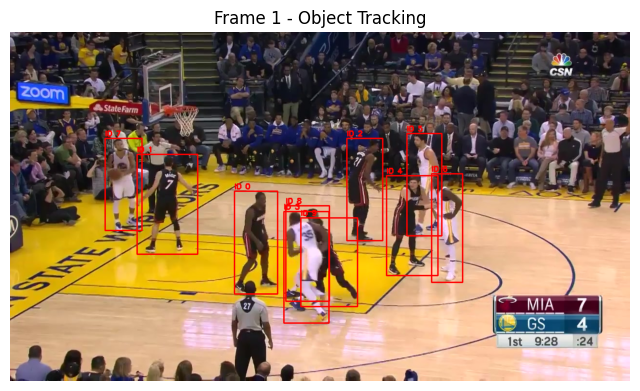

In [107]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

DATASET_PATH = "/kaggle/input/sportsmot/sportsmot_publish/dataset/train"

SEQUENCE_NAME = os.listdir(DATASET_PATH)[0]
SEQUENCE_PATH = os.path.join(DATASET_PATH, SEQUENCE_NAME)

GT_FILE = os.path.join(SEQUENCE_PATH, "gt", "gt.txt")
IMG_PATH = os.path.join(SEQUENCE_PATH, "img1")

columns = ["frame", "id", "x", "y", "w", "h", "conf", "class", "visibility"]
df = pd.read_csv(GT_FILE, names=columns)

print("Sample annotations from gt.txt:")
print(df.head())

print(f"Unique tracked objects: {df['id'].nunique()}")

def visualize_annotation(frame_number):
    frame_data = df[df["frame"] == frame_number]
    
    img_file = os.path.join(IMG_PATH, f"{frame_number:06d}.jpg") 
    if not os.path.exists(img_file):
        print(f"Image {img_file} not found!")
        return
    
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for _, row in frame_data.iterrows():
        x, y, w, h = int(row["x"]), int(row["y"]), int(row["w"]), int(row["h"])
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, f"ID {row['id']}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Frame {frame_number} - Object Tracking")
    plt.show()

visualize_annotation(1)


In [108]:
!pip install torch torchvision opencv-python matplotlib pandas

## Data Loader Class

In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SportsMOTDataset(Dataset):
    def __init__(self, root_dir, split_file, data_type="train", transform=None):

        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform
        self.sequences = self._load_sequences(split_file)
        self.data = self._load_annotations()

    def _load_sequences(self, split_file):
        with open(split_file, "r") as f:
            sequences = [line.strip() for line in f.readlines()]
        return sequences

    def _load_annotations(self):
        data = []
        for seq in self.sequences:
            img_path = os.path.join(self.root_dir, "dataset", self.data_type, seq, "img1")
            gt_path = os.path.join(self.root_dir, "dataset", self.data_type, seq, "gt", "gt.txt")

            if not os.path.exists(img_path):
                continue

            if self.data_type in ["train", "val"] and os.path.exists(gt_path):  # No gt for test set
                df = pd.read_csv(gt_path, header=None)
                df.columns = ["frame", "id", "x", "y", "w", "h", "conf", "class", "visibility"]
            else:
                df = None

            img_files = sorted(os.listdir(img_path))
            for img_file in img_files:
                frame_id = int(img_file.split('.')[0])
                img_full_path = os.path.join(img_path, img_file)

                if not os.path.exists(img_full_path):  # Skip missing images
                    continue  

                if df is not None:
                    frame_data = df[df["frame"] == frame_id].copy()

                    # Remove invalid bounding boxes (zero width or height)
                    frame_data = frame_data[(frame_data["w"] > 0) & (frame_data["h"] > 0)]

                    if frame_data.empty:
                        continue  
                else:
                    frame_data = None

                data.append((img_full_path, frame_data))
        
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, annotations = self.data[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image.shape[:2]

        if annotations is not None:
            boxes = annotations[["x", "y", "w", "h"]].values.astype(np.float32)

            # Normalizing and changing format
            boxes[:, 0] = (boxes[:, 0] + boxes[:, 2] / 2) / img_width  # x_center
            boxes[:, 1] = (boxes[:, 1] + boxes[:, 3] / 2) / img_height # y_center
            boxes[:, 2] /= img_width 
            boxes[:, 3] /= img_height 

            labels = np.ones((boxes.shape[0],), dtype=np.int64)
        else:
            boxes = np.empty((0, 4), dtype=np.float32)
            labels = np.empty((0,), dtype=np.int64)

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            labels = torch.tensor(transformed["labels"], dtype=torch.int64)

        return {"image": image, "boxes": boxes, "labels": labels}


**Defining transforms.**

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
        # A.Resize(640, 640),
        A.HorizontalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.2),
        A.Blur(p=0.2),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

def get_val_transforms():
    return A.Compose([
        # A.Resize(640, 640),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

def get_test_transforms():
    return A.Compose([
        # A.Resize(640, 640),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))


**Creating train, val and test datasets.**

In [11]:
root_dir = "/kaggle/input/sportsmot/sportsmot_publish"
split_file = os.path.join(root_dir, "splits_txt", "football.txt")

train_dataset = SportsMOTDataset(root_dir, split_file, data_type="train", transform=get_train_transforms())
val_dataset = SportsMOTDataset(root_dir, split_file, data_type="val", transform=get_val_transforms())
test_dataset = SportsMOTDataset(root_dir, split_file, data_type="test", transform=get_test_transforms())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: x)

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


**Displaying Samples of Football Data**

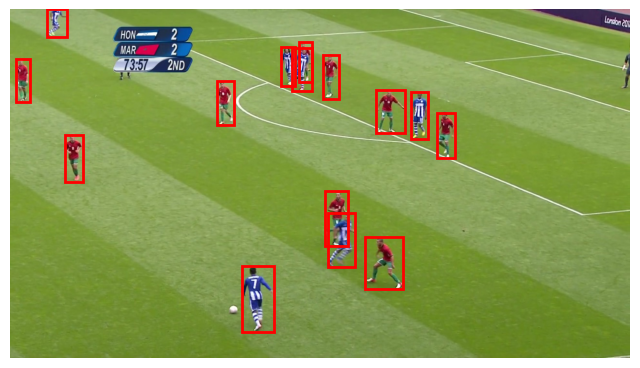

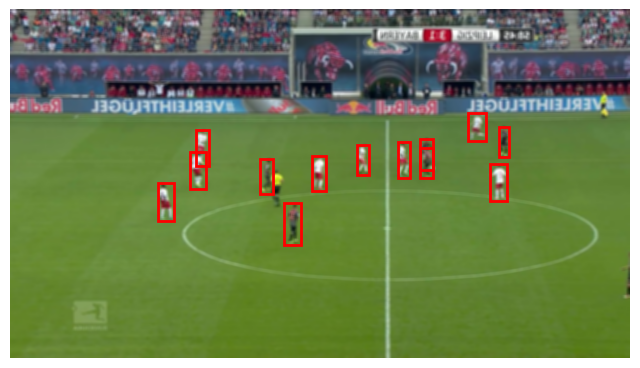

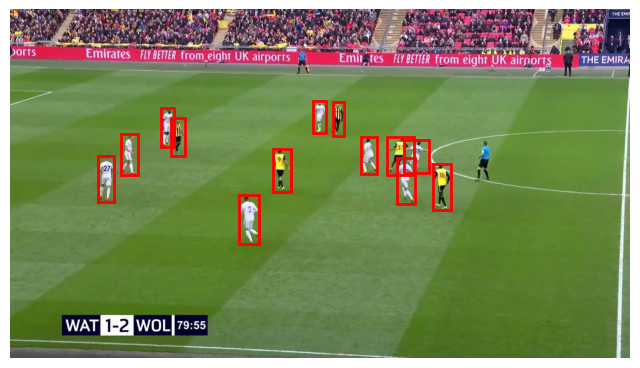

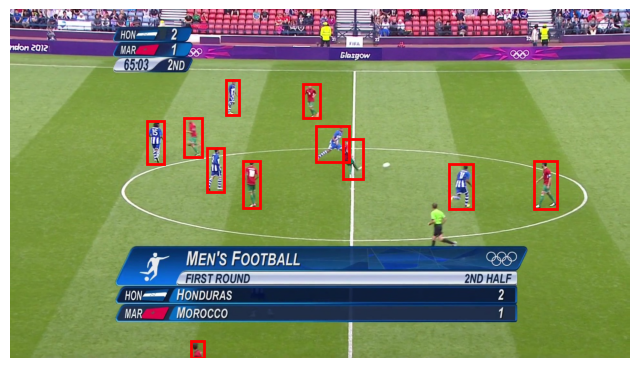

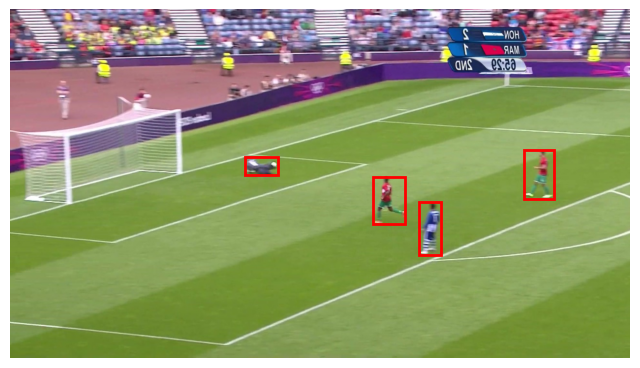

In [13]:
import random
import matplotlib.pyplot as plt

def plot_random_images_with_boxes(dataset, num_images=5):

    indices = random.sample(range(len(dataset)), num_images)  # Randomly

    for i in indices:
        sample = dataset[i]
        image = sample["image"].permute(1, 2, 0).cpu().numpy()
        boxes = sample["boxes"].cpu().numpy()

        # mean = np.array([0.485, 0.456, 0.406])
        # std = np.array([0.229, 0.224, 0.225])
        # image = (image * std + mean)  # Reverse normalization

        # Convert to correct range (0-1) for display
        # image = np.clip(image, 0, 1)

        # Convert back to pixel values
        img_height, img_width, _ = image.shape
        boxes[:, [0, 2]] *= img_width
        boxes[:, [1, 3]] *= img_height

        boxes[:, 0] -= boxes[:, 2] / 2 
        boxes[:, 1] -= boxes[:, 3] / 2
        boxes[:, 2] += boxes[:, 0] 
        boxes[:, 3] += boxes[:, 1] 

        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis("off")

        for box in boxes:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor="red", facecolor="none")
            plt.gca().add_patch(rect)

        plt.show() 

plot_random_images_with_boxes(train_dataset, num_images=5)

# Part 2

# 2.1 : Object Detection

## 2.1.1

### **Comparison of YOLOv8 vs. Faster R-CNN**
| Model        | Speed  | Accuracy  | Works for Real-Time? | Pros  | Cons  |
|-------------|---------|------------|----------------------|---------|---------|
| **YOLOv8**  |  Fast (Real-time) |  Good |  Yes (25+ FPS) | Fast, works well for tracking | Might miss small objects |
| **Faster R-CNN** |  Slower |  Higher | No (5-7 FPS) | Very accurate | Too slow for real-time |

---

### **Which Model is Better for SportsMOT?**
**YOLOv8 is the better choice for now** because:
   - It runs **faster than 25 FPS** (real-time requirement).
   - It detects multiple objects **quickly & efficiently**.
   - Many tracking models (like DeepSORT, ByteTrack) **are optimized for YOLO**.

**Faster R-CNN could be used for offline analysis**, but:
   - It is too **slow for real-time tracking**.
   - It requires **more computational resources**.

### **Decision: We Will Use YOLOv8**

---

## 2.1.2

**Converting the dataset format to YOLO format.**

In [3]:
import os
import shutil

dataset_root = "/kaggle/input/sportsmot/sportsmot_publish/dataset"
splits_root = "/kaggle/input/sportsmot/sportsmot_publish/splits_txt"
output_root = "/kaggle/working/yolo_dataset"

football_sequences = set()
football_file = os.path.join(splits_root, "football.txt")

with open(football_file, "r") as f:
    football_sequences = set(line.strip() for line in f)

for split in ["train", "val"]:
    os.makedirs(os.path.join(output_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_root, split, "labels"), exist_ok=True)

def convert_mot_to_yolo(sequence_path, split):
    
    seqinfo_path = os.path.join(sequence_path, "seqinfo.ini")
    with open(seqinfo_path, "r") as f:
        seqinfo = {line.split('=')[0]: line.split('=')[1].strip() for line in f if '=' in line}
    img_width = int(seqinfo["imWidth"])
    img_height = int(seqinfo["imHeight"])
    
    gt_path = os.path.join(sequence_path, "gt/gt.txt")
    with open(gt_path, "r") as f:
        annotations = [line.strip().split(",") for line in f]
    
    frame_annotations = {}
    for ann in annotations:
        frame_id, _, x, y, w, h, _, class_id, _ = map(float, ann[:9])
        frame_id = int(frame_id)
        
        # Normalize
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        
        if frame_id not in frame_annotations:
            frame_annotations[frame_id] = []
        frame_annotations[frame_id].append(f"{int(class_id-1)} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    
    for frame_id, ann_list in frame_annotations.items():
        img_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}.jpg"  # Add sequence name to make filename unique
        label_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}.txt"
        
        img_src = os.path.join(sequence_path, "img1", f"{frame_id:06d}.jpg")
        img_dst = os.path.join(output_root, split, "images", img_name)
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
        
        label_dst = os.path.join(output_root, split, "labels", label_name)
        with open(label_dst, "w") as f:
            f.write("\n".join(ann_list))

for split in ["train", "val"]:
    split_file = os.path.join(splits_root, f"{split}.txt")
    
    with open(split_file, "r") as f:
        sequences = [line.strip() for line in f]
    
    for seq in sequences:
        if seq in football_sequences:  # Only process football sequences
            sequence_path = os.path.join(dataset_root, split, seq)
            if os.path.exists(sequence_path):
                convert_mot_to_yolo(sequence_path, split)

print("Conversion complete. YOLO dataset is in:", output_root)

Conversion complete. YOLO dataset is in: /kaggle/working/yolo_dataset


In [2]:
yaml_content = """path: /kaggle/working/yolo_dataset
train: train/images
val: val/images

nc: 1
names: ["player"]
"""

yaml_path = "/kaggle/working/yolo_dataset/sportsmot.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"YAML file created at: {yaml_path}")

YAML file created at: /kaggle/working/yolo_dataset/sportsmot.yaml


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.6 MB/s eta 0:00:00a 0:00:01


In [4]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(data="/kaggle/working/yolo_dataset/sportsmot.yaml", epochs=15, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 83.8MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/sportsmot.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/train/labels... 11113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11113/11113 [00:10<00:00, 1087.66it/s]


train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/yolo_dataset/val/labels... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:08<00:00, 1052.07it/s]

val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000500.jpg: 1

val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.47G     0.9777     0.7741     0.8637        192        640: 100%|██████████| 695/695 [02:08<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:51<00:00,  5.47it/s]


                   all       9058     117024      0.871      0.906       0.92      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      3.25G     0.8587     0.4812     0.8407        229        640: 100%|██████████| 695/695 [02:05<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.81it/s]


                   all       9058     117024      0.889      0.922      0.925      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.73G     0.8337     0.4478     0.8357        235        640: 100%|██████████| 695/695 [02:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.89it/s]


                   all       9058     117024      0.887      0.918       0.93      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.52G      0.806     0.4266     0.8323        173        640: 100%|██████████| 695/695 [02:04<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.92it/s]


                   all       9058     117024      0.901      0.941      0.935      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      3.02G     0.7772     0.4076     0.8275        247        640: 100%|██████████| 695/695 [02:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]


                   all       9058     117024      0.907      0.926      0.941      0.752
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.22G     0.7306     0.3884     0.8241        111        640: 100%|██████████| 695/695 [01:59<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.81it/s]


                   all       9058     117024      0.891      0.913      0.908        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.24G     0.7083     0.3712     0.8209        114        640: 100%|██████████| 695/695 [01:59<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.908       0.92      0.922       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.21G      0.694     0.3599      0.818        107        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.912      0.927      0.932      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15       2.2G     0.6762     0.3468     0.8156        106        640: 100%|██████████| 695/695 [02:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.898      0.917      0.924      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.21G     0.6635     0.3379      0.813        118        640: 100%|██████████| 695/695 [01:58<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024      0.908      0.929      0.929      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.24G     0.6497     0.3294     0.8108        109        640: 100%|██████████| 695/695 [01:58<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.92it/s]


                   all       9058     117024      0.912      0.927      0.927      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.21G     0.6377     0.3202     0.8088        114        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:49<00:00,  5.78it/s]


                   all       9058     117024      0.915      0.924       0.93      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.23G      0.628     0.3128     0.8072        110        640: 100%|██████████| 695/695 [01:58<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.88it/s]


                   all       9058     117024      0.915      0.932      0.931      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.24G     0.6191     0.3058     0.8052        117        640: 100%|██████████| 695/695 [01:58<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:46<00:00,  6.08it/s]


                   all       9058     117024      0.916      0.933      0.919      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.21G     0.6072     0.2971     0.8042        106        640: 100%|██████████| 695/695 [01:57<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.914      0.934      0.926      0.757

15 epochs completed in 0.710 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:05<00:00,  4.33it/s]


                   all       9058     117024      0.915      0.924       0.93      0.758


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b8679265cc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

**Results**


image 1/1 /kaggle/working/yolo_dataset/val/images/v_G-vNjfx1GGc_c004_000410.jpg: 384x640 13 players, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


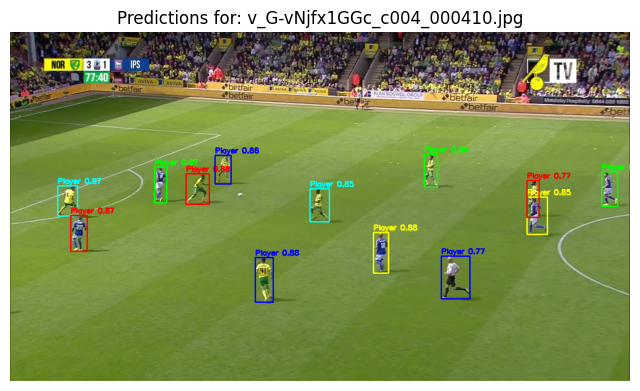


Bounding Boxes for v_G-vNjfx1GGc_c004_000410.jpg:
Player detected at [1221.737060546875, 288.5931091308594, 1254.754150390625, 359.0702819824219] with confidence 0.88
Player detected at [363.50579833984375, 292.74713134765625, 411.22418212890625, 355.83404541015625] with confidence 0.88
Player detected at [506.21453857421875, 465.08660888671875, 543.8341674804688, 557.3534545898438] with confidence 0.88
Player detected at [750.5712280273438, 413.94183349609375, 781.1268920898438, 497.84185791015625] with confidence 0.88
Player detected at [98.85287475585938, 317.54327392578125, 139.08326721191406, 379.90570068359375] with confidence 0.87
Player detected at [298.237548828125, 278.92413330078125, 323.5946044921875, 352.81939697265625] with confidence 0.87
Player detected at [125.38805389404297, 378.5985107421875, 159.41644287109375, 452.210205078125] with confidence 0.87
Player detected at [423.39166259765625, 254.66412353515625, 456.77349853515625, 313.78472900390625] with confidence 0

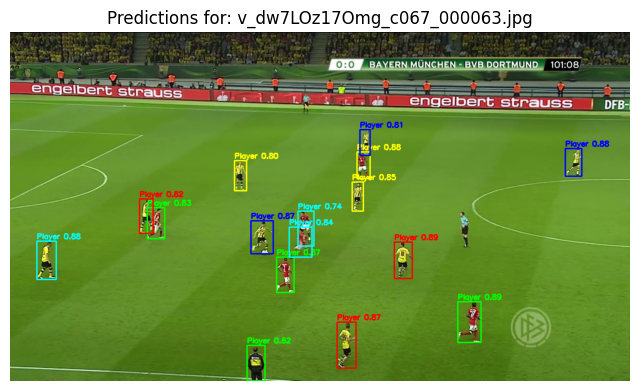


Bounding Boxes for v_dw7LOz17Omg_c067_000063.jpg:
Player detected at [924.1954345703125, 556.3711547851562, 972.2943115234375, 640.6909790039062] with confidence 0.89
Player detected at [793.437744140625, 433.78741455078125, 830.42578125, 508.70489501953125] with confidence 0.89
Player detected at [1146.1337890625, 240.52178955078125, 1180.642578125, 297.7523193359375] with confidence 0.88
Player detected at [716.27001953125, 247.84332275390625, 743.01904296875, 302.5654296875] with confidence 0.88
Player detected at [55.2538948059082, 431.69732666015625, 95.15895080566406, 510.10198974609375] with confidence 0.88
Player detected at [550.06640625, 464.74945068359375, 586.8922119140625, 537.6438598632812] with confidence 0.87
Player detected at [675.8040771484375, 598.98974609375, 714.1285400390625, 693.0792236328125] with confidence 0.87
Player detected at [497.70623779296875, 389.87713623046875, 543.0697631835938, 457.95745849609375] with confidence 0.87
Player detected at [706.88195

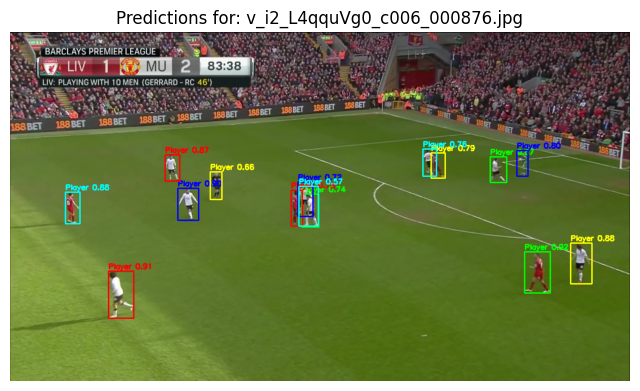


Bounding Boxes for v_i2_L4qquVg0_c006_000876.jpg:
Player detected at [1062.8106689453125, 453.5700378417969, 1115.3236083984375, 538.825439453125] with confidence 0.92
Player detected at [203.46426391601562, 493.378662109375, 255.13009643554688, 590.00244140625] with confidence 0.91
Player detected at [346.97137451171875, 322.03106689453125, 389.42083740234375, 388.10968017578125] with confidence 0.90
Player detected at [1157.2982177734375, 435.048095703125, 1201.8145751953125, 519.6519165039062] with confidence 0.88
Player detected at [114.73872375488281, 330.5516357421875, 144.00401306152344, 395.8770751953125] with confidence 0.88
Player detected at [991.6953125, 257.8360900878906, 1025.682861328125, 310.3113708496094] with confidence 0.87
Player detected at [320.66717529296875, 253.42416381835938, 350.56121826171875, 307.0442199707031] with confidence 0.87
Player detected at [1046.26416015625, 244.8387451171875, 1069.4794921875, 297.01220703125] with confidence 0.80
Player detecte

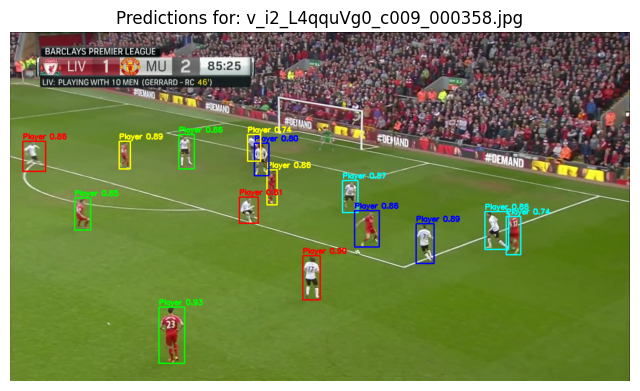


Bounding Boxes for v_i2_L4qquVg0_c009_000358.jpg:
Player detected at [307.8678894042969, 567.0278930664062, 360.1076354980469, 683.8394165039062] with confidence 0.93
Player detected at [604.8214111328125, 461.16326904296875, 640.6102294921875, 552.9512329101562] with confidence 0.90
Player detected at [838.8599243164062, 395.8873291015625, 875.7256469726562, 477.36151123046875] with confidence 0.89
Player detected at [225.338134765625, 225.27810668945312, 248.04876708984375, 282.4830017089844] with confidence 0.89
Player detected at [686.67578125, 306.8121337890625, 718.975830078125, 372.28887939453125] with confidence 0.87
Player detected at [348.64886474609375, 211.95407104492188, 380.29327392578125, 282.4565734863281] with confidence 0.86
Player detected at [26.947616577148438, 225.79376220703125, 73.011474609375, 287.3621826171875] with confidence 0.86
Player detected at [711.2030029296875, 368.9046630859375, 762.0914306640625, 443.8494873046875] with confidence 0.86
Player detec

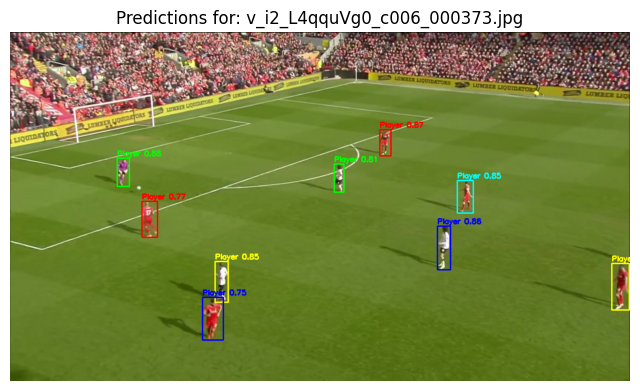


Bounding Boxes for v_i2_L4qquVg0_c006_000373.jpg:
Player detected at [221.32342529296875, 260.02862548828125, 246.32650756835938, 318.55975341796875] with confidence 0.88
Player detected at [763.54052734375, 201.61883544921875, 786.164306640625, 255.66455078125] with confidence 0.87
Player detected at [882.33349609375, 400.061279296875, 909.18115234375, 490.65216064453125] with confidence 0.86
Player detected at [423.68853759765625, 473.85906982421875, 450.38897705078125, 557.8394165039062] with confidence 0.85
Player detected at [923.937744140625, 306.567138671875, 956.5794677734375, 373.0625] with confidence 0.85
Player detected at [669.8626708984375, 272.50726318359375, 689.1231689453125, 330.30029296875] with confidence 0.81
Player detected at [272.14190673828125, 349.841796875, 304.15728759765625, 423.9222412109375] with confidence 0.77
Player detected at [397.04937744140625, 547.5730590820312, 440.38482666015625, 635.5476684570312] with confidence 0.75
Player detected at [1242.3

In [10]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")

val_images_path = "/kaggle/working/yolo_dataset/val/images"

sample_images = random.sample(os.listdir(val_images_path), 5)

colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)] 

for img_name in sample_images:
    img_path = os.path.join(val_images_path, img_name)

    results = model.predict(source=img_path, conf=0.5, save=False)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = results[0].boxes.xyxy
    confs = results[0].boxes.conf
    class_ids = results[0].boxes.cls.int()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        color = colors[i % len(colors)]

        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label = f"Player {confs[i]:.2f}"
        img = cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions for: {img_name}")
    plt.show()

    print(f"\nBounding Boxes for {img_name}:")
    for i, box in enumerate(boxes):
        print(f"Player detected at {box.tolist()} with confidence {confs[i]:.2f}")

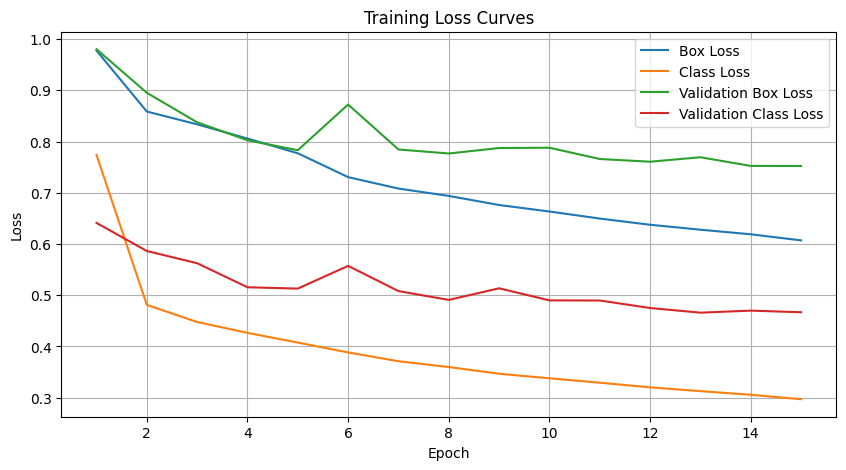

In [11]:
metrics_path = "runs/detect/train/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label="Box Loss")
plt.plot(df['epoch'], df['train/cls_loss'], label="Class Loss")
plt.plot(df['epoch'], df['val/box_loss'], label="Validation Box Loss")
plt.plot(df['epoch'], df['val/cls_loss'], label="Validation Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid()
plt.show()

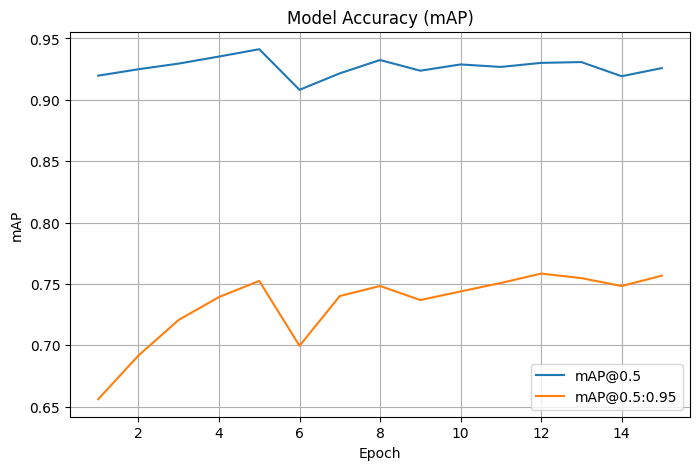

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], df.get('metrics/mAP50(B)', df.get('mAP50', None)), label="mAP@0.5")
plt.plot(df['epoch'], df.get('metrics/mAP50-95(B)', df.get('mAP50-95', None)), label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Model Accuracy (mAP)")
plt.legend()
plt.grid()
plt.show()

**Creating a video**

In [24]:
import os
import glob
import torch
import cv2

model = YOLO("runs/detect/train/weights/best.pt")

image_folder = '/kaggle/working/yolo_dataset/val/images'

image_paths = glob.glob(os.path.join(image_folder, 'v_2QhNRucNC7E_c017_*.jpg'))

image_paths.sort()

frame_width = 1280
frame_height = 720
fps = 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/kaggle/working/output_video.mp4', fourcc, fps, (frame_width, frame_height))

colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)]

for image_path in image_paths:
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model.predict(source=image_path, conf=0.5, save=False)

    boxes = results[0].boxes.xyxy
    confs = results[0].boxes.conf
    class_ids = results[0].boxes.cls.int()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        color = colors[i % len(colors)]

        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label = f"Player {confs[i]:.2f}"
        img = cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(img)

out.release()
cv2.destroyAllWindows()


image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000001.jpg: 384x640 20 players, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000002.jpg: 384x640 20 players, 7.1ms
Speed: 1.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000003.jpg: 384x640 19 players, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000004.jpg: 384x640 19 players, 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000005.jpg: 384x640 19 players, 6.2ms
Speed: 1.4ms preprocess, 6.2ms inference, 1.3ms postprocess per image at sha

**Printing Metrics**

In [14]:
metrics_path = "runs/detect/train/results.csv"
df = pd.read_csv(metrics_path)

print("Available columns:", df.columns)

last_epoch = df.iloc[-1]

precision = float(last_epoch['metrics/precision(B)'])
recall = float(last_epoch['metrics/recall(B)'])
map50 = float(last_epoch['metrics/mAP50(B)'])
map50_95 = float(last_epoch['metrics/mAP50-95(B)'])

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"mAP@0.5: {map50:.3f}")
print(f"mAP@0.5:0.95: {map50_95:.3f}")

Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
Precision: 0.906
Recall: 0.907
mAP@0.5: 0.910
mAP@0.5:0.95: 0.718


#### **Since we suppose to do tracking on Ball, we need to have a detector that detects ball. Since SportsMot doesn't have detected ball, i trained a detector on SoccerNet which has ball detected.**

# 2.1 : Object Detection on SoccerNet Dataset

**Extracting Track ids for each class and changing the dataset format to YOLO format**

In [1]:
import os
import shutil

dataset_root = "/kaggle/input/soccernet-tracking"
output_root = "/kaggle/working/yolo_dataset_SoccerNet"
# splits = ["train", "test"]

class_ids = {
    "player": 0,
    "ball": 1,
    "referee": 2
}

def get_class_track_ids(gameinfo_path):
    track_ids = {
        "player": [],
        "ball": [],
        "referee": []
    }
    
    with open(gameinfo_path, "r") as f:
        gameinfo = f.readlines()
        
    for line in gameinfo:
        if "trackletID" in line:
            # print(line)
            tracklet_split = line.split("=")
            tracklet_info = tracklet_split[1].strip().split(";")
            tracklet_id = tracklet_split[0].split('_')[1]
            tracklet_class = tracklet_info[0].strip() if len(tracklet_info) > 1 else ""
            # print(tracklet_id)
            # print(tracklet_class)

            if "ball" in tracklet_class:
                track_ids["ball"].append(int(tracklet_id.strip()))
            elif "player" in tracklet_class or "goalkeeper" in tracklet_class:
                track_ids["player"].append(int(tracklet_id.strip()))
            elif "referee" in tracklet_class:
                track_ids["referee"].append(int(tracklet_id.strip()))

    # print(track_ids["player"])
    # print(track_ids["ball"])
    # print(track_ids["referee"])
    return track_ids


def convert_sequence_to_yolo(sequence_path, split, track_ids, print_output=True):

    seqinfo_path = os.path.join(sequence_path, "seqinfo.ini")
    with open(seqinfo_path, "r") as f:
        seqinfo = {line.split('=')[0]: line.split('=')[1].strip() for line in f if '=' in line}
    img_width = int(seqinfo["imWidth"])
    img_height = int(seqinfo["imHeight"])
    
    gt_path = os.path.join(sequence_path, "gt/gt.txt")
    with open(gt_path, "r") as f:
        annotations = [line.strip().split(",") for line in f]
    
    frame_annotations = {}
    for ann in annotations:
        frame_id, track_id, x, y, w, h, _, _, _ = map(str.strip, ann[:9])

        if int(track_id.strip()) in track_ids["player"]:
            class_id = class_ids["player"]
        elif int(track_id.strip()) in track_ids["ball"]:
            class_id = class_ids["ball"]
        elif int(track_id.strip()) in track_ids["referee"]:
            class_id = class_ids["referee"]
        else:
            continue

        
        frame_id = int(frame_id)            
        
        x_center = (float(x) + float(w) / 2) / img_width
        y_center = (float(y) + float(h) / 2) / img_height
        norm_width = float(w) / img_width
        norm_height = float(h) / img_height
        
        if frame_id not in frame_annotations:
            frame_annotations[frame_id] = []
        
        frame_annotations[frame_id].append(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")

    for frame_id, ann_list in frame_annotations.items():
        
        img_name = f"{sequence}_{frame_id:06d}.jpg"
        label_name = f"{sequence}_{frame_id:06d}.txt"

        img_src = os.path.join(sequence_path, "img1", f"{frame_id:06d}.jpg")
        img_dst = os.path.join(output_root, split, "images", img_name)
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)

        label_dst = os.path.join(output_root, split, "labels", label_name)
        with open(label_dst, "w") as f:
            f.write("\n".join(ann_list))

for split in ["train", "test"]:
    os.makedirs(os.path.join(output_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_root, split, "labels"), exist_ok=True)

for split in ["train", "test"]:
    split_path = os.path.join(dataset_root, split)    
    for sequence in os.listdir(split_path):
        sequence_path = os.path.join(split_path, sequence)
        
        if os.path.isdir(sequence_path):
            gameinfo_path = os.path.join(sequence_path, "gameinfo.ini")
            track_ids = get_class_track_ids(gameinfo_path)

            convert_sequence_to_yolo(sequence_path, split, track_ids, print_output=True)

print("Sample conversion complete. YOLO dataset is saved in:", output_root)

Sample conversion complete. YOLO dataset is saved in: /kaggle/working/yolo_dataset_SoccerNet


In [3]:
yaml_content = """path: /kaggle/working/yolo_dataset_SoccerNet
train: train/images
val: test/images

nc: 3
names: ['player', 'ball', 'referee'] 
"""

yaml_path = "/kaggle/working/soccerNet.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"YAML file created at: {yaml_path}")

YAML file created at: /kaggle/working/soccerNet.yaml


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 15.9 MB/s eta 0:00:00a 0:00:01


In [6]:
from ultralytics import YOLO
import torch

model = YOLO("/kaggle/input/yolo_soccernet17/pytorch/default/1/Best17.pt")

model.train(
    data="/kaggle/working/soccerNet.yaml",
    epochs=10,
    imgsz=1088,
    patience=5
    # batch=32,
    # workers=4,
    # device='cuda' if torch.cuda.is_available() else 'cpu'
)

Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/yolo_soccernet17/pytorch/default/1/Best17.pt, data=/kaggle/working/soccerNet.yaml, epochs=10, time=None, patience=5, batch=16, imgsz=1088, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

train: Scanning /kaggle/working/yolo_dataset_SoccerNet/train/labels.cache... 42750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42750/42750 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset_SoccerNet/test/labels.cache... 36750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36750/36750 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-194_000585.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1088 train, 1088 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.51G      1.072     0.4755      0.937        236       1088: 100%|██████████| 2672/2672 [21:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:26<00:00,  3.52it/s]


                   all      36750     563233      0.823      0.645      0.687      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.49G      1.109     0.4989     0.9526        222       1088: 100%|██████████| 2672/2672 [20:45<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:25<00:00,  3.53it/s]


                   all      36750     563233      0.803       0.65      0.686      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.54G      1.115     0.5037     0.9544        228       1088: 100%|██████████| 2672/2672 [20:35<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:23<00:00,  3.55it/s]


                   all      36750     563233       0.82      0.668      0.699      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       6.5G      1.105     0.4957     0.9528        200       1088: 100%|██████████| 2672/2672 [20:32<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:24<00:00,  3.54it/s]


                   all      36750     563233      0.827      0.656      0.697      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.49G      1.089     0.4854     0.9471        179       1088: 100%|██████████| 2672/2672 [20:31<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:24<00:00,  3.55it/s]


                   all      36750     563233      0.808      0.656      0.689      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       6.5G      1.074     0.4733     0.9431        245       1088: 100%|██████████| 2672/2672 [20:31<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:23<00:00,  3.55it/s]


                   all      36750     563233       0.82       0.66        0.7      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.49G      1.058     0.4631     0.9382        199       1088: 100%|██████████| 2672/2672 [20:30<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:31<00:00,  3.47it/s]


                   all      36750     563233       0.82      0.658      0.698      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.51G      1.044     0.4538     0.9326        237       1088: 100%|██████████| 2672/2672 [20:33<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:23<00:00,  3.55it/s]


                   all      36750     563233      0.812      0.666      0.698      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.49G      1.028     0.4448     0.9293        226       1088: 100%|██████████| 2672/2672 [20:30<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:33<00:00,  3.45it/s]


                   all      36750     563233      0.815      0.663      0.698      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.49G      1.012     0.4346      0.924        210       1088: 100%|██████████| 2672/2672 [20:32<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [05:24<00:00,  3.54it/s]


                   all      36750     563233      0.814       0.66      0.695      0.414

10 epochs completed in 4.366 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1149/1149 [06:30<00:00,  2.94it/s]


                   all      36750     563233      0.821       0.66        0.7      0.417
                player      36750     484147      0.908      0.949      0.959       0.63
                  ball      33804      34129      0.646      0.371      0.395      0.145
               referee      30827      44957      0.907       0.66      0.745      0.477


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be198941570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

**Results**

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

image 1/1 /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-198_000285.jpg: 640x1088 20 players, 1 referee, 35.6ms
Speed: 4.7ms preprocess, 35.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 1088)


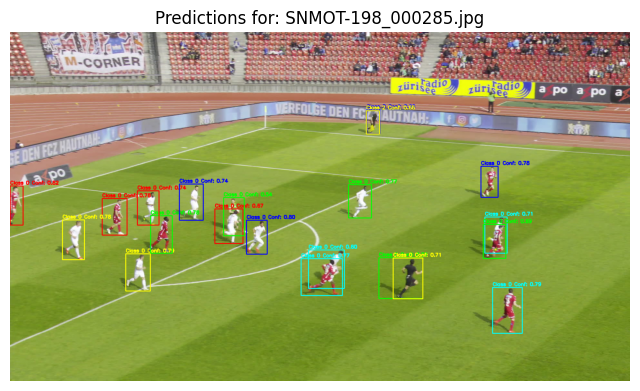


image 1/1 /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-200_000228.jpg: 640x1088 20 players, 6.6ms
Speed: 4.7ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 1088)


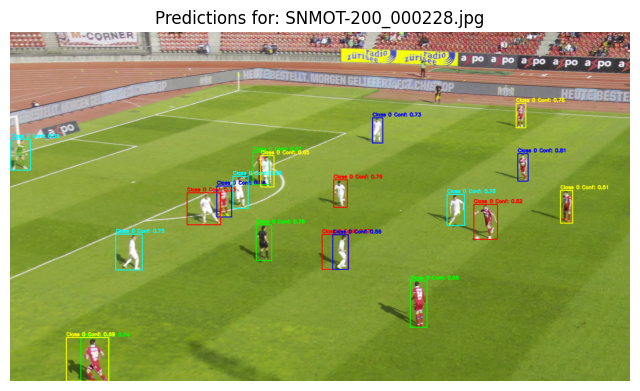


image 1/1 /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-148_000473.jpg: 640x1088 13 players, 1 ball, 1 referee, 6.6ms
Speed: 4.7ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 1088)


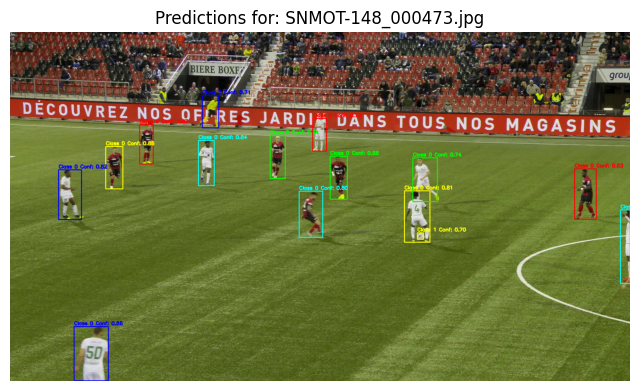


image 1/1 /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-125_000330.jpg: 640x1088 2 players, 1 referee, 6.5ms
Speed: 4.7ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)


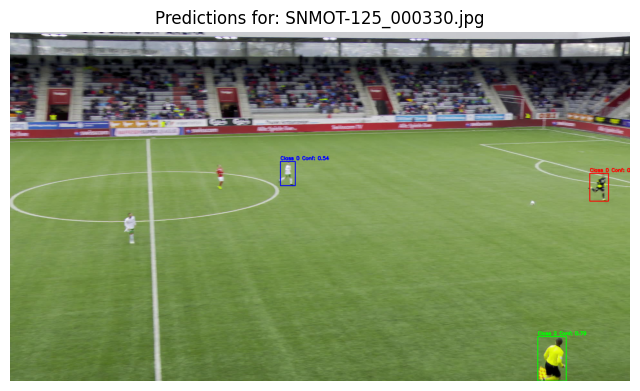


image 1/1 /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-190_000093.jpg: 640x1088 20 players, 6.4ms
Speed: 4.6ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 1088)


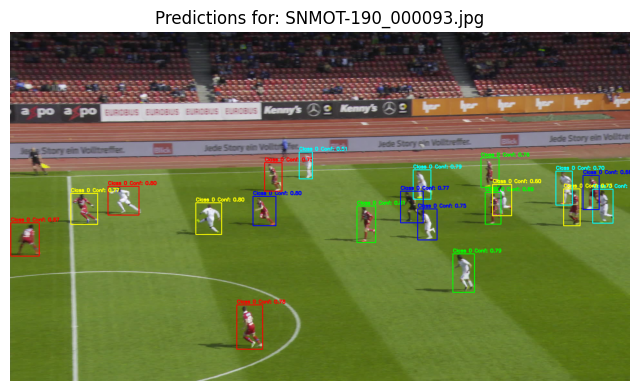


image 1/1 /kaggle/working/yolo_dataset_SoccerNet/test/images/SNMOT-117_000137.jpg: 640x1088 9 players, 1 referee, 6.5ms
Speed: 4.8ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)


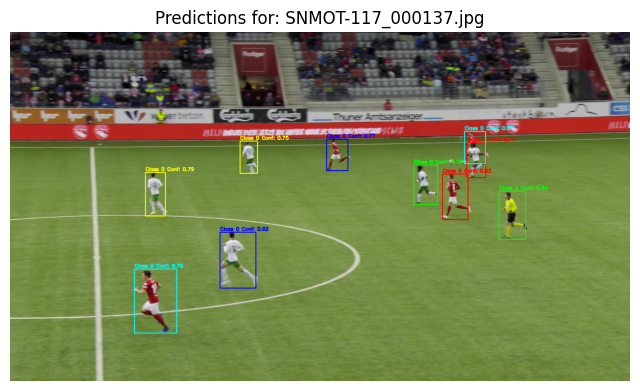

In [7]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch
from ultralytics import YOLO

model = YOLO("runs/detect/train2/weights/best.pt")

val_images_path = "/kaggle/working/yolo_dataset_SoccerNet/test/images"

sample_images = random.sample(os.listdir(val_images_path), 6)

colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

for img_name in sample_images:
    img_path = os.path.join(val_images_path, img_name)

    results = model.predict(source=img_path, conf=0.5, save=False)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = results[0].boxes.xyxy
    confs = results[0].boxes.conf
    class_ids = results[0].boxes.cls.int()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        color = colors[i % len(colors)]

        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label = f"Class {class_ids[i]} Conf: {confs[i]:.2f}"
        img = cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions for: {img_name}")
    plt.show()

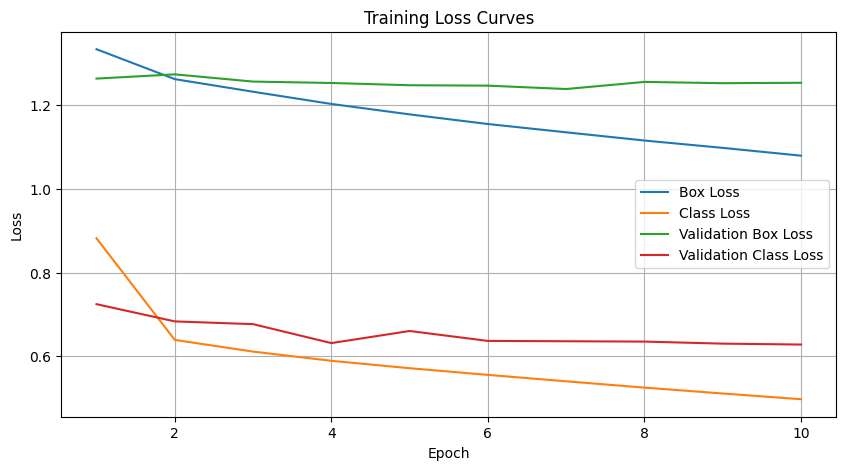

In [16]:
import pandas as pd
metrics_path = "/kaggle/working/runs/detect/train2/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label="Box Loss")
plt.plot(df['epoch'], df['train/cls_loss'], label="Class Loss")
plt.plot(df['epoch'], df['val/box_loss'], label="Validation Box Loss")
plt.plot(df['epoch'], df['val/cls_loss'], label="Validation Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid()
plt.show()

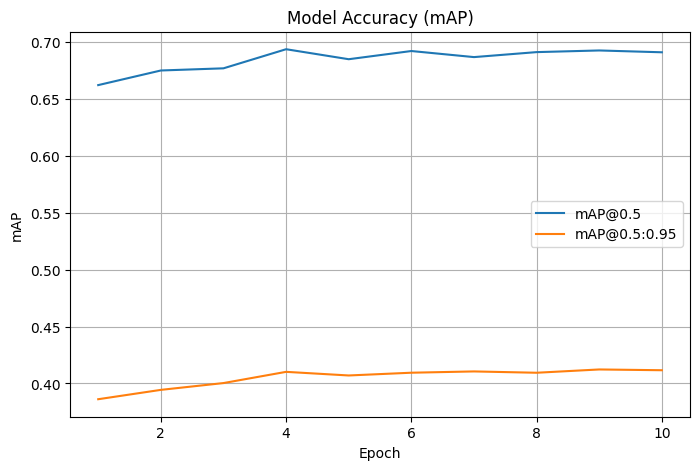

In [15]:
metrics_path = "/kaggle/working/runs/detect/train2/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], df.get('metrics/mAP50(B)', df.get('mAP50', None)), label="mAP@0.5")
plt.plot(df['epoch'], df.get('metrics/mAP50-95(B)', df.get('mAP50-95', None)), label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Model Accuracy (mAP)")
plt.legend()
plt.grid()
plt.show()

**Creating Sample Video**

In [25]:
import os
import glob
import torch
import cv2

model = YOLO("/kaggle/input/best_model_soccernet/pytorch/default/1/Best Model (2).pt")

image_folder = '/kaggle/working/yolo_dataset/val/images'

image_paths = glob.glob(os.path.join(image_folder, 'v_2QhNRucNC7E_c017_*.jpg'))

image_paths.sort()

frame_width = 1280
frame_height = 720
fps = 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/kaggle/working/output_video2.mp4', fourcc, fps, (frame_width, frame_height))

colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)]

for image_path in image_paths:
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    results = model.predict(source=image_path, conf=0.5, save=False)

    boxes = results[0].boxes.xyxy
    confs = results[0].boxes.conf
    class_ids = results[0].boxes.cls.int()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        color = colors[i % len(colors)]

        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label = f"Class {class_ids[i]} Conf: {confs[i]:.2f}"
        img = cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(img)

out.release()
cv2.destroyAllWindows()


image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000001.jpg: 640x1088 12 players, 1 ball, 2 referees, 38.2ms
Speed: 4.2ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000002.jpg: 640x1088 11 players, 1 ball, 3 referees, 10.8ms
Speed: 3.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000003.jpg: 640x1088 12 players, 1 ball, 1 referee, 10.8ms
Speed: 3.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000004.jpg: 640x1088 12 players, 1 ball, 3 referees, 10.8ms
Speed: 4.1ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 1088)

image 1/1 /kaggle/working/yolo_dataset/val/images/v_2QhNRucNC7E_c017_000005.jpg: 640x108

**Other Metrics**

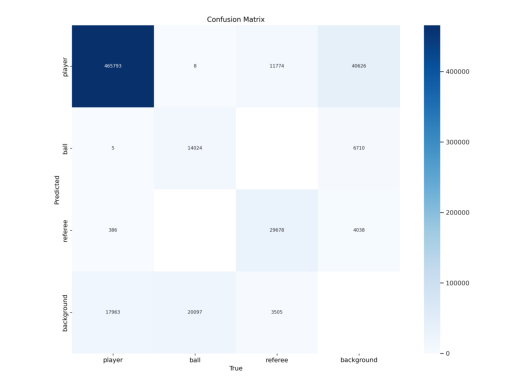

In [14]:
import matplotlib.pyplot as plt
import cv2

image_path = '/kaggle/working/runs/detect/train2/confusion_matrix.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off') 
plt.show()


In [20]:
import pandas as pd

metrics_path = "/kaggle/working/runs/detect/train2/results.csv"
df = pd.read_csv(metrics_path)

print("Available columns:", df.columns)

last_epoch = df.iloc[-1]

precision = float(last_epoch['metrics/precision(B)'])
recall = float(last_epoch['metrics/recall(B)'])
map50 = float(last_epoch['metrics/mAP50(B)'])
map50_95 = float(last_epoch['metrics/mAP50-95(B)'])

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"mAP@0.5: {map50:.3f}")
print(f"mAP@0.5:0.95: {map50_95:.3f}")

Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
Precision: 0.819
Recall: 0.657
mAP@0.5: 0.691
mAP@0.5:0.95: 0.412


# 2.2 : SOT

## 2.2.1

### **I Will Choose SiamRPN++**
#### **Rationale for Selecting SiamRPN++ for Tracking**

In this project, we have opted for **SiamRPN++** (Siamese Region Proposal Network++) to track players in sports videos. This algorithm is designed to deliver a powerful combination of accuracy, robustness, and real-time speed, which makes it highly effective for tracking fast-moving objects, such as players, in dynamic sports videos.

1. **Optimizing Precision and Efficiency**:
   - **SiamRPN++** is an advanced iteration of **SiamRPN**, crafted to achieve a perfect balance between tracking accuracy and computational performance. This is critical in sports video tracking, where processing real-time video frames quickly and accurately is essential.
   - The **Siamese network** structure enables **SiamRPN++** to efficiently compare the object template (from the first frame) with the search region in later frames, reducing computational requirements while maintaining excellent tracking accuracy.

2. **Resilience to Occlusions and Fast Motion**:
   - Sports videos often involve scenarios where objects (like players) are obscured by other players or elements in the environment. **SiamRPN++** is highly effective in such situations, using deep learning features to track objects even with partial visibility or rapid movement.
   - The **Region Proposal Network (RPN)** within **SiamRPN++** enhances its ability to handle fast-moving objects, making it especially suited for sports settings where players frequently move at high speeds across the field.

3. **End-to-End Learning Approach**:
   - Unlike conventional tracking algorithms, which rely on manually designed features, **SiamRPN++** benefits from an end-to-end training approach. This means the entire tracking process, from feature extraction to bounding box prediction, is optimized simultaneously. This enables the tracker to be customized specifically for tracking sports players, resulting in improved accuracy and efficiency.
   - The end-to-end training enhances the model’s generalization ability, allowing it to perform well across different sports scenarios without needing manual fine-tuning for each new application.

4. **Performance Enhancements Over SiamRPN**:
   - **SiamRPN++** offers several significant improvements over its predecessor, **SiamRPN**, such as a stronger backbone network (e.g., **ResNet**), advanced feature fusion methods, and refined region proposals. These enhancements make the tracking more reliable and accurate, even in complex situations involving rapid movements or partial occlusions.

5. **Real-Time Tracking Capability**:
   - Despite being a deep learning-based algorithm, **SiamRPN++** is optimized to function at real-time speeds, which is crucial for analyzing sports videos. It ensures uninterrupted, continuous tracking without delays, making it ideal for live video analysis and other real-time applications.

---


#### **Comparison with CSRT Tracker**:

| Feature                    | **SiamRPN++**                                      | **CSRT Tracker**                                 |
|----------------------------|---------------------------------------------------|-------------------------------------------------|
| **Accuracy**                | High accuracy, especially in occlusions and motion | Lower accuracy in complex scenarios             |
| **Speed**                   | Real-time, but computationally heavier            | Faster and lighter, suitable for real-time with fewer resources |
| **Robustness to Occlusions**| Highly robust, can handle partial visibility      | Struggles with occlusions and fast movements    |
| **Performance with Motion** | Excellent for fast-moving objects (sports context) | Limited by the speed of correlation filters     |
| **Training Requirement**    | Requires large datasets and end-to-end training   | No training required, uses predefined features  |
| **Flexibility**             | High flexibility for different sports scenarios   | More rigid, less adaptable to varying conditions|
| **Ease of Use**             | Requires training and fine-tuning                 | Quick setup, no training necessary              |

#### **Conclusion**:
**SiamRPN++** is the ideal choice for Single Object Tracking in sports video analysis due to its combination of robustness, accuracy, and real-time performance. It outperforms traditional algorithms like **CSRT Tracker** in challenging environments, such as high-speed motion, occlusions, and transformations. Despite being more computationally demanding, its superior accuracy and ability to handle complex tracking scenarios make it the best option for tracking players in sports videos.

---

## 2.2.2

In [1]:
!git clone https://github.com/STVIR/pysot.git

Cloning into 'pysot'...
remote: Enumerating objects: 433, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 433 (delta 0), reused 0 (delta 0), pack-reused 430 (from 2)
Receiving objects: 100% (433/433), 6.35 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [2]:
%cd pysot
!pip install -r requirements.txt

/kaggle/working/pysot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00


### Creating Video of Frames

In [18]:
import cv2
import os
from glob import glob

img_folder = "/kaggle/input/soccernet-tracking/test/SNMOT-116/img1/"
output_video_path = "/kaggle/working/SNMOT-060_video.mp4"

image_files = sorted(glob(os.path.join(img_folder, "*.jpg")))

if not image_files:
    raise ValueError("No images found in the specified directory!")

frame = cv2.imread(image_files[0])
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, fourcc, 25, (width, height))

for img_file in image_files:
    frame = cv2.imread(img_file)
    video_writer.write(frame)
    
video_writer.release()

print(f"Video saved at: {output_video_path}")

Video saved at: /kaggle/working/SNMOT-060_video.mp4


**Algorithm Implementation**

In [19]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker


def track_and_evaluate(sequence, start_frame, track_id, num_frames, dataset_dir, model_cfg, model_weights):

    cfg.defrost()
    cfg.merge_from_file(model_cfg)
    cfg.CUDA = torch.cuda.is_available()
    cfg.freeze()

    siam_model = ModelBuilder()
    siam_model.load_state_dict(torch.load(model_weights, map_location="cuda" if cfg.CUDA else "cpu"))
    siam_model.eval().cuda() if cfg.CUDA else siam_model.eval()

    def compute_iou(box_a, box_b):
        ax1, ay1, aw, ah = box_a
        bx1, by1, bw, bh = box_b

        ax2, ay2 = ax1 + aw, ay1 + ah
        bx2, by2 = bx1 + bw, by1 + bh

        inter_w = max(0, min(ax2, bx2) - max(ax1, bx1))
        inter_h = max(0, min(ay2, by2) - max(ay1, by1))
        intersection = inter_w * inter_h

        area_a, area_b = aw * ah, bw * bh
        union = area_a + area_b - intersection

        return intersection / union if union > 0 else 0

    sequence_path = os.path.join(dataset_dir, sequence)
    gt_file = os.path.join(sequence_path, "gt", "gt.txt")
    frame_dir = os.path.join(sequence_path, "img1")

    gt_df = pd.read_csv(gt_file, header=None, sep=",", usecols=[0, 1, 2, 3, 4, 5], 
                        names=["frame", "id", "x", "y", "w", "h"])

    output_video = f"/kaggle/working/{sequence}_tracked.mp4"

    # initial bounding box
    first_bbox = gt_df[(gt_df["frame"] == start_frame) & (gt_df["id"] == track_id)]
    if first_bbox.empty:
        raise ValueError(f"Initial bounding box not found for target {track_id} in {sequence}.")

    x_init, y_init, w_init, h_init = first_bbox.iloc[0, 2:6]

    first_frame_path = os.path.join(frame_dir, f"{start_frame:06d}.jpg")
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        raise ValueError("First frame image not found.")

    tracker = build_tracker(siam_model)
    tracker.init(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB), (x_init, y_init, w_init, h_init))

    video_writer = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"mp4v"), 25, 
                                   (first_frame.shape[1], first_frame.shape[0]))

    iou_scores = []
    heatmap_coords = []
    y_true, y_pred = [], []

    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith(".jpg")])
    frame_numbers = [int(f.split(".")[0]) for f in frame_files]
    total_frames = max(frame_numbers)

    end_frame = min(start_frame + num_frames, total_frames)

    # Process frames
    for f_id in range(start_frame, end_frame):
        img_path = os.path.join(frame_dir, f"{f_id:06d}.jpg")
        frame = cv2.imread(img_path)
        
        if frame is None:
            continue

        pred_bbox = tracker.track(frame)["bbox"]
        
        gt_bbox = gt_df[(gt_df["frame"] == f_id) & (gt_df["id"] == track_id)]
        if not gt_bbox.empty:
            gt_bbox = gt_bbox.iloc[0, 2:6].values
            iou = compute_iou(pred_bbox, gt_bbox)
            iou_scores.append(iou)

            y_true.append(1)
            y_pred.append(1 if iou >= 0.5 else 0)

            x1, y1, w1, h1 = map(int, pred_bbox)
            heatmap_coords.extend([(i, j) for i in range(x1, x1 + w1) for j in range(y1, y1 + h1)])

        cv2.rectangle(frame, (int(pred_bbox[0]), int(pred_bbox[1])), 
                      (int(pred_bbox[0] + pred_bbox[2]), int(pred_bbox[1] + pred_bbox[3])), 
                      (0, 255, 0), 2)

        video_writer.write(frame)

    video_writer.release()

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

    return {
        "iou_scores": iou_scores,
        "heatmap_coords": heatmap_coords,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

**Creating Video of Output**

#### Tracking One Player

In [20]:
SEQUENCE = "SNMOT-060"
START_FRAME = 200
TRACK_ID = 4 
NUM_FRAMES = 200 

results = track_and_evaluate(
    sequence=SEQUENCE, 
    start_frame=START_FRAME, 
    track_id=TRACK_ID, 
    num_frames=NUM_FRAMES, 
    dataset_dir="/kaggle/input/soccernet-tracking/train", 
    model_cfg="/kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr/config.yaml", 
    model_weights="/kaggle/input/sot/pytorch/default/1/SiamRPN R50 Model.pth"
)

<ipython-input-19-673e6978137e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siam_model.load_state_dict(torch.load(model_weights, map_location="cuda" if cfg.CUDA else "

## 2.2.4 : Player

### **Evaluation Metrics**

In tracking and object detection, there are several key **evaluation metrics** used to assess the performance of a model. These metrics help in understanding how well the tracker is performing in terms of its accuracy and robustness. Let’s go through some of these metrics in detail:

#### **1. Success Rate**

- **What is it?**  
  The **success rate** measures how often the model successfully tracks the object with a certain level of accuracy, defined by a threshold for **IoU (Intersection over Union)**. This threshold represents the minimum acceptable overlap between the predicted bounding box and the ground truth bounding box.

- **How is it calculated?**  
  The success rate is calculated by evaluating the **IoU threshold** across all frames. For each frame, if the **IoU between the predicted and ground truth bounding boxes** exceeds a set threshold (e.g., 0.5), it counts as a **successful detection**. The success rate is then calculated as:
  
  $$
  \text{Success Rate} = \frac{\text{Number of successful detections}}{\text{Total number of frames}}
  $$

- **Why it matters?**  
  Success rate is a **direct indicator** of how frequently the model is able to track the object **with sufficient accuracy** across the frames. A high success rate means that the model is effectively **following the object**.

---

#### **2. Average IoU (Intersection over Union)**

- **What is it?**  
  **IoU** is a measure of how well the predicted bounding box overlaps with the ground truth bounding box. It is calculated as the area of intersection between the predicted and true bounding boxes, divided by the area of their union.

  $$
  \text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
  $$

- **How is it calculated?**  
  The **average IoU** is the **mean of the IoU values** for all frames in a sequence. It is calculated by taking the **IoU** for each frame and averaging them:
  
  $$
  \text{Average IoU} = \frac{1}{N} \sum_{i=1}^{N} \text{IoU}_i
  $$
  where \( N \) is the total number of frames in the dataset.

- **Why it matters?**  
  The **average IoU** is a crucial metric for measuring the **accuracy** of the predicted bounding boxes over time. A higher average IoU means the model is consistently **tracking the object with high accuracy**, while a lower IoU indicates that the model’s predictions are less precise.

---

#### **3. Precision**

- **What is it?**  
  **Precision** measures the **accuracy of the positive predictions** made by the model. Specifically, it is the ratio of **true positive** detections to the total number of **positive predictions** (both true positives and false positives).

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
  $$

- **Why it matters?**  
  Precision indicates how well the model avoids making **false positive errors** (i.e., predicting an object where there is none). A high precision means that when the model makes a prediction, it is **likely to be correct**, while low precision indicates that the model is **over-predicting** or making many false detections.

---

#### **4. Recall**

- **What is it?**  
  **Recall** measures the **model's ability to detect all relevant objects**. It is the ratio of **true positive** detections to the total number of **actual objects** (both true positives and false negatives).

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
  $$

- **Why it matters?**  
  Recall indicates how well the model identifies all instances of the object. A high recall means the model is able to **detect most objects**, while a low recall indicates that the model is **missing a lot of objects** (i.e., it is not sensitive enough to detect all true positives).

---

#### **5. F1 Score**

- **What is it?**  
  The **F1 score** is the **harmonic mean** of precision and recall. It provides a balance between **precision** and **recall** and is especially useful when there is an **uneven class distribution** (e.g., many true negatives or when the cost of false positives and false negatives is unequal).

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}
  $$

- **Why it matters?**  
  The F1 score gives a more **holistic view** of the model’s performance. A **high F1 score** indicates that the model performs well in both **precision** and **recall**, meaning it is both **accurate** (low false positives) and **sensitive** (low false negatives).

---

### **Summary of Key Metrics**
- **Success Rate**: Measures how often the tracker successfully tracks the object based on IoU thresholds.
- **Average IoU**: Measures the average overlap between predicted and ground truth bounding boxes, indicating tracking accuracy.
- **Precision**: Measures how accurate the model’s positive predictions are.
- **Recall**: Measures how well the model detects all relevant objects.
- **F1 Score**: A balanced measure that considers both precision and recall, giving an overall performance evaluation.


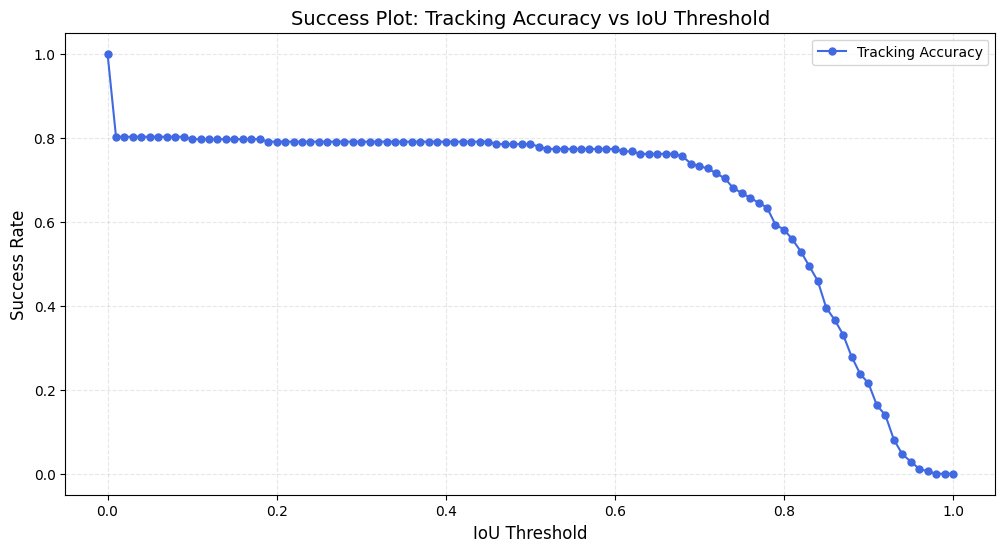

In [21]:
thresholds = np.linspace(0, 1, 101)
success_rates = [np.sum(np.array(results["iou_scores"]) >= t) / len(results["iou_scores"]) for t in thresholds]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, success_rates, marker="o", linestyle="-", color="royalblue", markersize=5, label="Tracking Accuracy")
plt.xlabel("IoU Threshold", fontsize=12)
plt.ylabel("Success Rate", fontsize=12)
plt.title("Success Plot: Tracking Accuracy vs IoU Threshold", fontsize=14)
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.show()

In [22]:
iou = results["iou_scores"]
print(f"Average IoU: {np.mean(iou):.2f}")
print(f"Precision: {results['precision']:.2f}")
print(f"Recall: {results['recall']:.2f}")
print(f"F1 Score: {results['f1_score']:.2f}")

Average IoU: 0.66
Precision: 1.00
Recall: 0.78
F1 Score: 0.88


## 2.2.6: Player

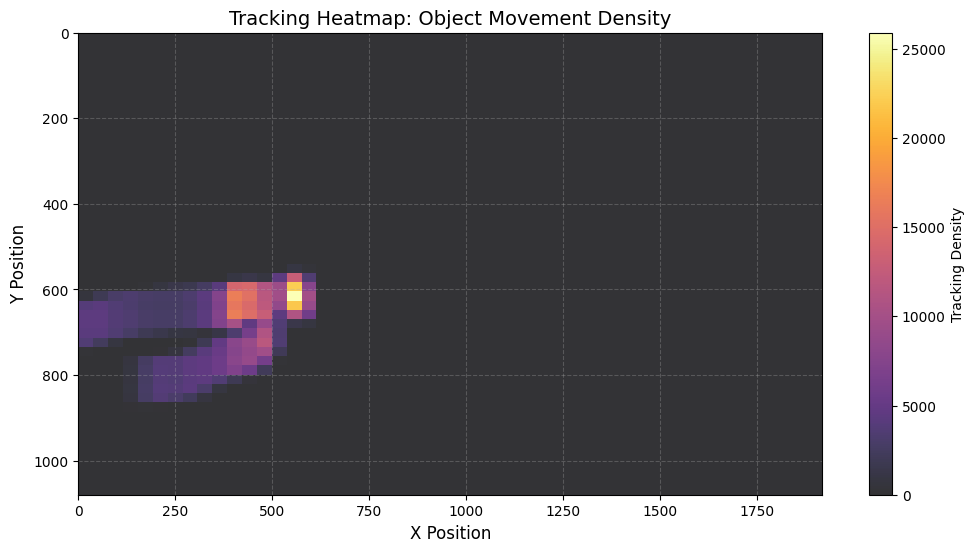

In [23]:
heatmap_coords = np.array(results["heatmap_coords"])
plt.figure(figsize=(12, 6))
plt.hist2d(heatmap_coords[:, 0], heatmap_coords[:, 1], bins=50, cmap="inferno", alpha=0.8, range=[[0, 1920], [0, 1080]])
plt.gca().invert_yaxis()
plt.colorbar(label="Tracking Density")
plt.xlabel("X Position", fontsize=12)
plt.ylabel("Y Position", fontsize=12)
plt.title("Tracking Heatmap: Object Movement Density", fontsize=14)
plt.grid(alpha=0.3, linestyle="--")
plt.show()


#### Tracking Ball

## 2.2.4 : Ball

In [24]:
SEQUENCE = "SNMOT-061"
START_FRAME = 300
TRACK_ID = 1
NUM_FRAMES = 150

results = track_and_evaluate(
    sequence=SEQUENCE, 
    start_frame=START_FRAME, 
    track_id=TRACK_ID, 
    num_frames=NUM_FRAMES, 
    dataset_dir="/kaggle/input/soccernet-tracking/train", 
    model_cfg="/kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr/config.yaml", 
    model_weights="/kaggle/input/sot/pytorch/default/1/SiamRPN R50 Model.pth"
)

<ipython-input-19-673e6978137e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siam_model.load_state_dict(torch.load(model_weights, map_location="cuda" if cfg.CUDA else "

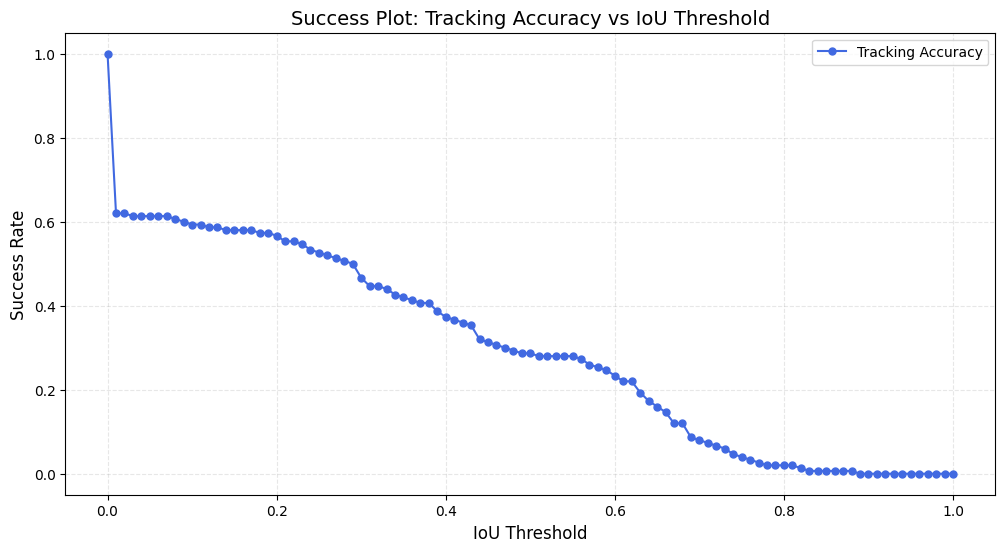

In [25]:
thresholds = np.linspace(0, 1, 101)
success_rates = [np.sum(np.array(results["iou_scores"]) >= t) / len(results["iou_scores"]) for t in thresholds]

plt.figure(figsize=(12, 6))
plt.plot(thresholds, success_rates, marker="o", linestyle="-", color="royalblue", markersize=5, label="Tracking Accuracy")
plt.xlabel("IoU Threshold", fontsize=12)
plt.ylabel("Success Rate", fontsize=12)
plt.title("Success Plot: Tracking Accuracy vs IoU Threshold", fontsize=14)
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.show()

In [26]:
iou = results["iou_scores"]
print(f"Average IoU: {np.mean(iou):.2f}")
print(f"Precision: {results['precision']:.2f}")
print(f"Recall: {results['recall']:.2f}")
print(f"F1 Score: {results['f1_score']:.2f}")

Average IoU: 0.29
Precision: 1.00
Recall: 0.29
F1 Score: 0.45


## 2.2.6 : Ball

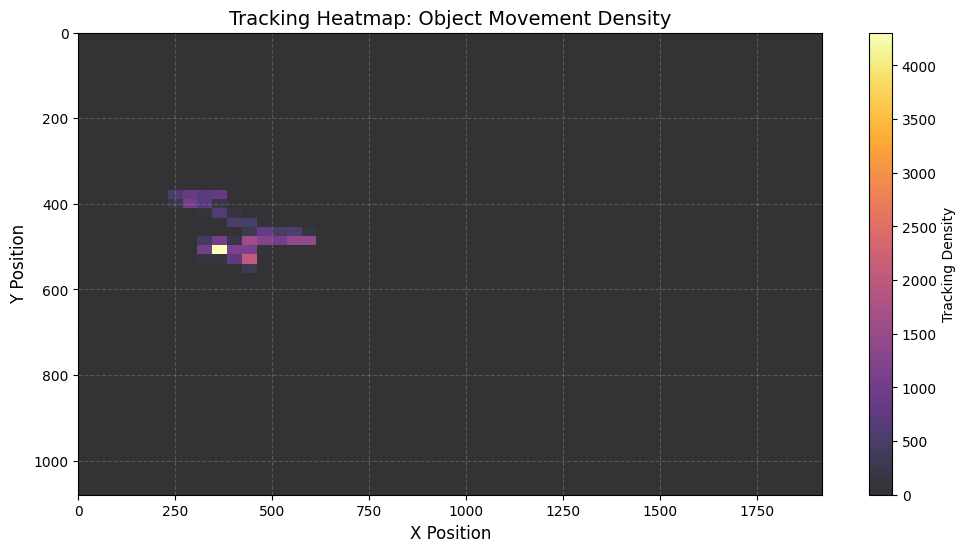

In [27]:
heatmap_coords = np.array(results["heatmap_coords"])
plt.figure(figsize=(12, 6))
plt.hist2d(heatmap_coords[:, 0], heatmap_coords[:, 1], bins=50, cmap="inferno", alpha=0.8, range=[[0, 1920], [0, 1080]])
plt.gca().invert_yaxis()
plt.colorbar(label="Tracking Density")
plt.xlabel("X Position", fontsize=12)
plt.ylabel("Y Position", fontsize=12)
plt.title("Tracking Heatmap: Object Movement Density", fontsize=14)
plt.grid(alpha=0.3, linestyle="--")
plt.show()

## 2.2.3

**Siamese Networks in Object Tracking**

Siamese networks are a type of deep learning architecture designed to measure the **similarity** between two inputs. In object tracking, the core idea is to use a Siamese network to compare the **current frame** with the **previous frame** or the **initial frame** to track the object.

These networks consist of **two identical subnetworks** that share the same weights and process two inputs separately. These subnetworks usually consist of convolutional layers that extract **feature maps** from images. After extracting features, the network computes a **similarity score** between the two input images (e.g., the current frame and the template image of the object). 

- **Training Process**: During training, the network learns to minimize the difference between the features of the same object across different frames while maximizing the difference between features of different objects. The goal is to train the network to recognize the same object even if its appearance changes slightly (due to movement).
  
- **Tracking Process**: During tracking, the network compares the **current frame** with the **previous frame** or the **initial object image** and outputs a **bounding box** around the object, depending on the similarity score. It identifies where the object is most likely to be in the new frame by measuring the similarity between the template (initial frame) and the candidate regions in the current frame.

---

**How Visual Changes Affect Tracking in Siamese Networks**

Siamese networks rely heavily on **consistent and reliable visual features** across frames to calculate similarity. When visual conditions change—such as due to **occlusion**, **scale variation**, or **illumination changes**—the features may be distorted or lost, causing the tracker to struggle. Here’s why these challenges arise:

### **1. Occlusion**
**Occlusion** occurs when part or all of the object being tracked is temporarily blocked by another object or part of the scene. For example, a person might walk behind a pillar, or an object may overlap with another one, causing the target object to be hidden from the view of the camera.

- **What happens during occlusion?**
  - **Loss of object visibility**: The object becomes invisible or partially visible, so the **visual features** (edges, textures, shapes) used to identify the object are no longer visible.
  - **Disruption in feature comparison**: Since Siamese networks rely on matching features between the template (initial frame) and the current frame, when occlusion occurs, the region of interest becomes unavailable, and the network cannot perform an effective comparison.
  - **Object disappears from view**: The object may completely disappear from the frame (e.g., moving behind a large object), which means the model cannot track it until it reappears.

- **Impact on tracking**: When the object is occluded, the tracker loses information about its **location and appearance**, leading to a **poor similarity score**. This can result in the tracker either **losing track of the object** or making an inaccurate prediction when the object reappears.

### **2. Scale Variation**
**Scale variation** refers to changes in the size of the object due to its movement towards or away from the camera or changes in perspective (e.g., zooming in or out).

- **What happens during scale variation?**
  - **Changes in object size**: The object may appear **larger** or **smaller** depending on whether it is moving closer to or further away from the camera.
  - **Distortion of visual features**: Siamese networks rely on the size and shape of the object to match the template with the current frame. When the object’s size changes, the **features** (edges, corners, textures) in the template and current frame might no longer align.
  - **Resolution changes**: The resolution of the object in the image may change as the size fluctuates. This can cause fine details to either become **blurred** or **stretched**, which alters the object’s appearance across frames.

- **Impact on tracking**: If the **mismatch** between the template and the current object size is significant, the **similarity score** will degrade, making it difficult for the network to track the object. This can lead to **tracking drift** or the **loss of object location**.

### **3. Illumination Change**
**Illumination change** occurs when lighting conditions in the scene vary, causing the object's appearance to change. This could happen due to natural lighting shifts (e.g., moving from sunlight to shade) or artificial lighting changes.

- **What happens during illumination change?**
  - **Changes in object appearance**: The object may **appear brighter or darker** under different lighting, with colors shifting and textures becoming harder to distinguish. For instance, an object that is bright and distinct in sunlight may appear dark and shadowed when moving into a shaded area.
  - **Distortion of visual features**: Trackers like Siamese networks rely on consistent visual features (e.g., colors, edges, textures). However, under different lighting conditions, these features may become **washed out** or distorted. The object may appear featureless or blurry in low light.
  - **Brightness shifts**: The overall **brightness** and **contrast** of the object can change, affecting the sharpness and clarity of features. As a result, the tracker may fail to match the object if the lighting changes significantly between frames.

- **Impact on tracking**: Because Siamese networks measure similarity by comparing **visual features**, significant changes in lighting can cause the features to **no longer match**. This can lead to **tracking errors**, where the object’s identity is lost, or the tracker fails to identify the object correctly under new lighting conditions.

---

### **Why These Visual Changes Are Problematic for Siamese Networks**
Siamese networks are designed to compare **visual features** between the template image and the current frame. They excel in environments where the object remains largely consistent in terms of:

- **Shape**
- **Size**
- **Color**
- **Texture**

However, when **visual conditions change**, such as during **occlusion**, **scale variation**, or **illumination changes**, the **feature similarity** between the current frame and the template image becomes weaker. This is problematic for the following reasons:

- **Feature Mismatch**: The features in the current frame may no longer match those in the template image, causing the network to fail in recognizing the object.
- **Loss of Context**: If the object is **partially occluded** or changes **size significantly**, the network may **fail to track** the object accurately.
- **Inaccurate Bounding Box**: Since the bounding box depends on the similarity score, visual changes like scale variation or lighting shifts can lead to **incorrect bounding box predictions** or **drifting of the object location**.

---


## 2.2.5

### **SiamRPN++ Performance Evaluation on SoccerNet Dataset**

The **SiamRPN++ tracker** delivers satisfactory results on the **SoccerNet dataset**, but its performance is challenged by specific conditions. These limitations mainly arise when tracking fast-moving objects such as the ball, when objects exit the frame, and when visual factors like **occlusion**, **scale changes**, and **lighting variations** occur. Below is an overview of these challenges:

---

#### **Tracking Fast-Moving Objects (Ball Handling)**

- **Issue**: The **SiamRPN++** tracker works by comparing the current frame with a reference image (usually the previous frame). The tracker relies heavily on the **similarity** between these frames to locate the object.
- **Challenge**: For fast-moving objects like the **ball**, especially during a **shot**, the movement between consecutive frames is so large that the tracker struggles to find the object in the current frame. The model is unable to search over a sufficiently large area and often fails to match the object accurately.
- **Impact**: This leads to the tracker **losing track** of the ball, as the **large displacement** between frames reduces the **similarity score**, making it difficult to correctly predict the ball's new position.

---

#### **Object Loss When Moving Out of View**

- **Issue**: As a **single-object tracker**, **SiamRPN++** initializes based on the detection and does not rely on continuous updates from the detector during tracking. This limits its adaptability to sudden changes in the object's location.
- **Challenge**: When an object, such as a player or the ball, moves out of the frame (e.g., when it goes out of view or off the screen), the tracker **loses sight** of the object and cannot recover its position until the object reappears in the frame.
- **Impact**: As the model cannot **reinitialize** or **recover the object’s location**, it may mistakenly track a different object or fail to track the original one, resulting in **tracking errors** or **misidentification**.

---

#### **Challenges Due to Visual Disturbances: Occlusion and Illumination Variations**

- **Occlusion**: When objects are temporarily blocked from view, such as a player obscuring the ball, the **SiamRPN++ tracker** cannot see the object and thus loses its ability to track it.
- **Scale Variation**: When an object’s size changes (e.g., if a player moves closer or farther from the camera), the visual features used by the tracker may no longer align, resulting in **tracking failure** or inaccurate location predictions.
- **Illumination Change**: Variations in lighting, such as a shift from bright sunlight to shadow or artificial light, alter the appearance of the object. This inconsistency in visual features affects the **feature comparison** process, making it difficult for the model to track the object accurately under varying lighting conditions.

- **Impact**: **Occlusion**, **scale variation**, and **illumination changes** all introduce significant challenges to the tracker’s ability to **maintain a consistent match** across frames. These changes can lead to **tracking inaccuracies** or complete **loss of tracking**, especially in dynamic and unpredictable environments like soccer games.

---

### **Conclusion**

The **SiamRPN++ tracker** is effective for tracking players, but it faces significant challenges when tracking objects like the **ball**, especially during **fast movements** or when objects move out of the frame. Additionally, visual challenges like **occlusion**, **scale variation**, and **illumination change** further complicate tracking. 

To address these issues, improvements such as better handling of **fast-moving objects**, the ability to **recover objects** that exit the frame, and enhanced techniques for dealing with **visual changes** (like occlusion and lighting variation) could improve the model's robustness and overall tracking performance.

# 2.3 : MOT

## 2.3.1

### Comparison of Tracking Algorithms: FairMOT, ByteTrack, DeepSORT, and SORT

#### **1. FairMOT:**
- **Core Method**: A unified framework for both detection and tracking, using a shared feature backbone to extract spatial-temporal information.
- **Strengths**:
  - High tracking accuracy, especially in crowded environments (MOTA, ID F1 score).
  - Strong handling of occlusions, using both appearance and motion information.
  - Suitable for multi-object scenarios with complex interactions.
- **Weaknesses**:
  - Computationally expensive due to the integration of detection and tracking.
  - Slower performance in real-time applications or on lower-end hardware.

#### **2. ByteTrack:**
- **Core Method**: Uses a lightweight tracking-by-detection approach, focusing on filtering low-confidence detections for more precise tracking.
- **Strengths**:
  - Extremely efficient and real-time friendly, suitable for moderate hardware.
  - High accuracy, especially for simpler tracking tasks.
  - Robust in handling partial occlusions and managing multiple objects.
- **Weaknesses**:
  - Less precise in complex environments compared to FairMOT, due to lack of joint detection and tracking.
  - Struggles slightly in very dense crowds.

#### **3. DeepSORT:**
- **Core Method**: Extends SORT with deep learning for appearance feature extraction to help track objects over time.
- **Strengths**:
  - Good accuracy in dynamic scenarios, especially with occlusions.
  - More efficient than FairMOT and suitable for moderate-density scenarios.
- **Weaknesses**:
  - Not as effective in dense crowds as FairMOT or ByteTrack.
  - Relies on high-quality pre-trained detection models (e.g., YOLO) for optimal performance.

#### **4. SORT (Simple Online and Realtime Tracking):**
- **Core Method**: Uses Kalman filters and the Hungarian algorithm, associating objects based on position and velocity.
- **Strengths**:
  - Extremely fast and simple to implement.
  - Low computational cost, ideal for real-time performance.
- **Weaknesses**:
  - Very low accuracy, especially in crowded and complex scenarios.
  - Struggles with occlusions and identity switches, lacking appearance features.

---

### Why Choose **ByteTrack** Among the Four Algorithms?

#### **1. Efficiency and Real-Time Performance:**
- **ByteTrack** provides a strong balance of speed and accuracy, making it suitable for **real-time applications**, such as sports video tracking, where fast processing is essential. 
- **FairMOT**, though more accurate, is computationally more expensive and less efficient for real-time use. **DeepSORT** uses deep learning for appearance features, adding computational overhead. On the other hand, **SORT** is very fast but lacks accuracy in complex scenarios.

#### **2. Accuracy and Handling of Occlusions:**
- **ByteTrack** has been shown to outperform **DeepSORT** in **accuracy**, particularly in scenarios with **occlusions**. In sports, players may often overlap or get temporarily occluded, and ByteTrack handles such situations more effectively by filtering out low-confidence detections.
- While **FairMOT** also handles occlusions well, its **computational complexity** makes it less ideal for environments where real-time performance is needed.

#### **3. Robustness in Crowded and Complex Scenes:**
- **ByteTrack** performs excellently in environments like **sports videos**, where multiple objects (players, the ball) move quickly and interact with each other. It handles **partial occlusions** and **low-confidence detections** effectively, ensuring stable tracking even in crowded situations.
- **FairMOT** excels in highly dense and complex scenes but comes at the cost of higher computational demands. **DeepSORT** and **SORT** fall short when it comes to tracking in very crowded environments.

#### **4. Scalability and Flexibility:**
- **ByteTrack** offers **scalability** across various datasets, including those with complex motion patterns and interactions. It works efficiently on real-time streams and large video data without significant performance loss.
- **FairMOT** can handle large datasets well but is better suited for high-resource environments. **DeepSORT** and **SORT** are less scalable for complex, real-time, or large-scale scenarios.

---

## 2.3.2

### **Relationship Between Object Detection and Object Tracking Algorithms**

Object detection and object tracking are two interrelated tasks in the field of computer vision. Their roles are distinct but complementary, and both play crucial parts in multi-object tracking (MOT) tasks, particularly in dynamic environments like sports videos or autonomous driving. Here’s a breakdown of their functions and how they interact:

#### **1. Object Detection:**
- **Core Task**: Object detection algorithms identify and locate objects within individual frames of a video. These algorithms output bounding boxes along with class labels and confidence scores.
- **Key Tasks**:
  - **Detection**: Identifying objects in each frame.
  - **Localization**: Drawing bounding boxes around objects.
  - **Classification**: Assigning a label to each detected object (e.g., "player," "ball").
- **Common Object Detection Algorithms**:
  - **YOLO** (You Only Look Once)
  - **Faster R-CNN** (Region-based Convolutional Neural Network)
  - **SSD** (Single Shot Multibox Detector)

#### **2. Object Tracking:**
- **Core Task**: Object tracking algorithms focus on maintaining the identity of objects across multiple frames in a video. After receiving initial detections, the tracker associates these detections over time to follow the same object’s movement.
- **Key Tasks**:
  - **Tracking**: Associating objects across frames.
  - **Prediction**: Estimating future positions based on motion.
  - **Occlusion Handling**: Managing cases where objects are temporarily hidden or overlap.
- **Common Object Tracking Algorithms**:
  - **SORT** (Simple Online and Real-time Tracking)
  - **DeepSORT** (Deep Learning-based SORT)
  - **Kalman Filter-based Trackers**

#### **3. Relationship Between Detection and Tracking**:
- **Detection → Tracking**: The first step in tracking is the detection of objects in the initial frame. The object detector identifies objects and provides bounding boxes. These detections are then passed to the tracking algorithm to keep track of the objects' identities across successive frames.
  
- **Tracker Needs Detection**: A tracker needs initial detections to start. Without detection, the tracker wouldn’t know where to begin. The detection outputs, like bounding boxes and class labels, guide the tracker in associating objects in subsequent frames.

- **Tracking Without Repeated Detection**: Ideally, once the tracker has identified an object, it can continue to track it without requiring new detections. However, if an object temporarily disappears or is occluded, the tracker might lose it, and the detector will need to re-identify the object in later frames.

<!-- - **Tracking Without Detection**: Some trackers, like **DeepSORT**, combine **appearance features** (from deep learning models) and **motion data** (via Kalman filters). This enables tracking even when fresh detections are unavailable, handling occlusions or changes in appearance more robustly. -->

---

### **Combining Detection and Tracking for MOT:**
In the case of **Multi-Object Tracking (MOT)**, object detection and tracking are **highly intertwined**:

1. **Detection Output**:
   - The object detector identifies and localizes objects frame-by-frame.
   - Example output format for detections:
     ```
     [frame_id, x, y, width, height, confidence, class_id]
     ```
   - For instance, the SoccerNet-Tracking dataset provides **precomputed detections** in the `det/` folder.

2. **Tracking Algorithm**:
   - The tracking algorithm receives the **detections** and assigns **track IDs** to each object.
   - It tracks these objects over time, ensuring consistent identification across frames.
   - Example output format for tracking:
     ```
     [frame_id, track_id, x, y, width, height, class_id]
     ```

3. **How Detection Becomes Tracking Input**:
   - **Detection Models** (e.g., YOLO, Faster R-CNN) predict **bounding boxes** for objects in each frame.
   - **Tracking Models** (e.g., ByteTrack, DeepSORT) associate detections over time using:
     - **Kalman Filters** (SORT, DeepSORT) for motion prediction.
     - **IoU-based matching** for short-term tracking.
     - **Re-identification (ReID)** features (DeepSORT, FairMOT) for long-term tracking.
     - **Low-confidence detection integration** (ByteTrack) to improve associations.

   **Example** (for ByteTrack):
   - **Detection** (Frame 1):
     ```
     1, 100, 150, 50, 80, 0.9, player
     1, 300, 200, 40, 60, 0.8, ball
     ```
   - **Tracking** (ByteTrack associates the detections into tracklets):
     ```
     1, 5, 100, 150, 50, 80, player  # Player tracked as ID 5
     1, 8, 300, 200, 40, 60, ball    # Ball tracked as ID 8
     ```

---

### **Why Detection and Tracking Work Well Together**:
1. **Efficiency**: Detection algorithms can be computationally expensive, especially in dense environments. Using tracking, only **initial detections** need to be performed for each object, with the tracker updating the positions across frames. This reduces computational cost by avoiding full re-detection in every frame.

2. **Robustness**: By combining detection and tracking, the system can handle issues like **occlusion** or **fast movement** more effectively. Even if an object disappears temporarily, the tracker can resume tracking once it reappears.

3. **Identity Persistence**: Tracking ensures that the identity of each object is maintained across frames, even in the presence of occlusion or when objects overlap. This is especially important in dynamic environments like sports tracking, where multiple objects interact.

---

### **Conclusion:**
- **Object detection** and **object tracking** serve complementary roles in computer vision. **Detection** identifies objects in each frame, while **tracking** ensures their identities are maintained across multiple frames.
- The integration of these tasks is crucial for tasks like **multi-object tracking**, which requires both accurate detection and robust tracking across time.
- For **real-time tracking** in complex environments like sports videos, algorithms like **ByteTrack** offer an ideal solution, leveraging the power of both detection and tracking for efficient and accurate results.

## 2.3.3

### **Assignment Process in ByteTrack Using the Hungarian Algorithm**

The assignment process in ByteTrack refers to the task of matching **detections** from the current frame with **existing tracklets** from previous frames. This process ensures that each object is tracked consistently, maintaining its identity across frames. ByteTrack uses a **two-stage assignment process**, where the **Hungarian Algorithm** plays a crucial role in finding the optimal matches between detections and tracks.

#### **1. Assignment Process in ByteTrack:**

**Step 1: Matching High-Confidence Detections:**
1. **Object detection** is performed using a model like YOLO, which generates detections with confidence scores.
2. **High-confidence detections** (above a threshold) are selected for matching. These detections are considered reliable and are matched to existing tracklets.
3. The matching between detections and tracks is done using **Intersection over Union (IoU)**, which measures the overlap between detection bounding boxes and existing track boxes.
4. The **Hungarian Algorithm** is used to optimize this matching process by solving the **assignment problem**. It assigns each high-confidence detection to the most appropriate tracklet based on the IoU.

**Step 2: Matching Low-Confidence Detections:**
1. Detections with **low confidence** are retained and used for a second round of matching.
2. These low-confidence detections are matched to remaining unmatched tracklets using **IoU**, but with a lower confidence threshold.
3. If a match is found, the low-confidence detection is assigned to the existing tracklet. If no match is found, a new tracklet is created for the object.
4. Tracks are removed if they fail to match any detection over multiple frames, ensuring efficient management of tracks.

---

#### **2. The Hungarian Algorithm for Matching:**

The **Hungarian Algorithm** is employed in ByteTrack to solve the **optimal assignment problem** between detections and tracklets. Here's how it works in ByteTrack:

1. **Cost Matrix Construction**:
   - A **cost matrix** is created, where:
     - The **rows** represent existing tracklets.
     - The **columns** represent new detections.
     - The **values** in the matrix are the cost of assigning a detection to a tracklet, calculated using the **IoU** (and sometimes appearance features for Re-ID).
     - A **low cost** implies a better match between a detection and a tracklet.

2. **Row and Column Reduction**:
   - The smallest value in each row and column is subtracted from all elements in that row/column.
   - This transformation ensures that at least one zero exists in each row and column.

3. **Covering Zeros**:
   - The Hungarian Algorithm tries to **cover all zeros** in the cost matrix using the **fewest number of lines** (both horizontal and vertical).
   - If the number of lines used equals the number of rows/columns, the optimal matching is found.

4. **Optimal Assignment**:
   - The algorithm then selects the **optimal one-to-one assignment** of detections to tracks, ensuring that the overall matching cost is minimized.

---

#### **3. Why Use the Hungarian Algorithm in ByteTrack?**

- **Optimal Matching**: The Hungarian Algorithm ensures that detections are optimally assigned to tracklets by minimizing the total cost, which helps reduce **ID switches** and improves tracking consistency.
- **Efficient**: The algorithm runs in **polynomial time** (O(n³)), making it feasible for real-time applications.
- **Handling Occlusions**: The algorithm's robustness is crucial in dealing with occlusions, ensuring that objects are consistently tracked even when they are temporarily hidden or overlapping.
- **Minimizing Errors**: It reduces matching errors by considering the entire cost matrix and finding the most suitable match for each detection.

---

### **Conclusion:**
ByteTrack's **two-stage assignment process** efficiently matches detections to tracklets, using the **Hungarian Algorithm** to ensure optimal and accurate assignments. By first matching high-confidence detections and then revisiting low-confidence detections, ByteTrack ensures stable tracking, reduces **identity switches**, and handles occlusions effectively. The Hungarian Algorithm plays a central role in this process by finding the best matches between detections and existing tracks, leading to **state-of-the-art performance** in multi-object tracking.

## 2.3.4 : ByteTrack

In [1]:
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack

Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007 (from 1)
Receiving objects: 100% (2007/2007), 79.60 MiB | 41.50 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
/kaggle/working/ByteTrack


In [2]:
!pip install motmetrics
!pip install ultralytics
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 16.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.6 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
import cv2
import torch
import numpy as np
import motmetrics as mm
import random
from tqdm import tqdm
from ultralytics import YOLO
import supervision as sv


def load_model(model_weights: str):
    model = YOLO(model_weights)
    return model


def initialize_tracker():
    tracker = sv.ByteTrack()
    return tracker


def get_frame_paths(frames_folder: str):
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')],
                         key=lambda x: int(x.split('.')[0]))
    return frame_files


def get_video_writer(first_frame, output_video_path):
    height, width = first_frame.shape[:2]
    video_writer = cv2.VideoWriter(
        output_video_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        25,
        (width, height)
    )
    return video_writer


def track_and_annotate(frame, model, tracker, track_colors, frame_idx):
    
    results = model(frame, conf=0.25, iou=0.7, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    detections = tracker.update_with_detections(detections)

    frame_tracking_results = []
    for i in range(len(detections.xyxy)):
        x1, y1, x2, y2 = map(int, detections.xyxy[i])
        track_id = int(detections.tracker_id[i])

        frame_tracking_results.append([
            frame_idx + 1,
            track_id,
            x1,
            y1,
            x2 - x1,
            y2 - y1
        ])

        if track_id not in track_colors:
            track_colors[track_id] = (
                random.randint(0, 255),
                random.randint(0, 255),
                random.randint(0, 255)
            )

        color = track_colors[track_id]
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        label_text = f"Track #{track_id}"
        cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    return frame_tracking_results


def track_soccernet(frames_folder: str, model_weights: str, output_video_path: str) -> tuple:

    model = load_model(model_weights)
    tracker = initialize_tracker()

    frame_files = get_frame_paths(frames_folder)
    first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
    video_writer = get_video_writer(first_frame, output_video_path)

    tracking_results = []
    track_colors = {}

    for frame_idx, frame_name in tqdm(enumerate(frame_files), total=len(frame_files)):
        frame_path = os.path.join(frames_folder, frame_name)
        frame = cv2.imread(frame_path)

        frame_tracking_results = track_and_annotate(frame, model, tracker, track_colors, frame_idx)

        tracking_results.extend(frame_tracking_results)

        video_writer.write(frame)

    video_writer.release()

    return tracking_results, frame_files


In [5]:
frames_folder = "/kaggle/input/soccernet-tracking/train/SNMOT-072/img1"
model_weights = "/kaggle/input/yolo_soccernet17/pytorch/default/1/Best17.pt"
output_video_path = "/kaggle/working/MOT_ByteTrack_72.mp4"

tracking_results, sorted_frames = track_soccernet(
    frames_folder=frames_folder,
    model_weights=model_weights,
    output_video_path=output_video_path
)

print(f"Tracking completed. Results saved to {output_video_path}")
print(f"Total tracked objects: {len(set([x[1] for x in tracking_results]))}")

100%|██████████| 750/750 [00:48<00:00, 15.45it/s]


Tracking completed. Results saved to /kaggle/working/MOT_ByteTrack_72.mp4
Total tracked objects: 69


## 2.3.5

### **MOT Evaluation Metrics**

These are **Multi-Object Tracking (MOT)** metrics used to evaluate the performance of tracking algorithms. Each metric measures different aspects of how well the tracker maintains object identities across frames. Here's an explanation of each metric:

### **1. MOTA (Multi-Object Tracking Accuracy):**
- **What it shows**: MOTA is a comprehensive performance measure that combines three types of errors:
  - **Misses**: When an object is not tracked (false negative).
  - **False Positives**: When a non-existent object is tracked (false positive).
  - **ID Switches**: When a tracked object is assigned the wrong ID.
- **Higher values are better**, indicating fewer errors in object tracking.

### **2. MOTP (Multi-Object Tracking Precision):**
- **What it shows**: MOTP measures the average localization accuracy of the tracked objects. It is the average distance between the predicted locations of the tracked objects and their ground truth positions.
- **Higher values are better**, indicating that the tracker is accurately locating objects.

### **3. IDF1 (ID F1 Score):**
- **What it shows**: This metric balances the precision and recall of tracking **IDs**. It takes into account both:
  - **Precision**: The fraction of correct ID assignments.
  - **Recall**: The fraction of ground truth objects correctly assigned an ID.
- **Higher values are better**, indicating fewer **ID switches** and better identity consistency.

### **4. Recall:**
- **What it shows**: Recall measures the proportion of **ground truth objects** that have been successfully tracked. It is the fraction of true positives out of all the objects that should have been tracked.
- **Higher values are better**, indicating that the tracker is catching most of the objects.

### **5. Precision:**
- **What it shows**: Precision measures how many of the tracked objects are **correctly assigned** (true positives). It is the fraction of correct predictions among all the predicted objects.
- **Higher values are better**, indicating that most of the tracked objects are actual true positives.

### **6. Num_Objects:**
- **What it shows**: The total number of **ground truth objects** that should have been tracked in the video.
- **Useful for**: Understanding the scale of the tracking problem.

### **7. Num_Matches:**
- **What it shows**: The number of **correct matches** between the tracker and ground truth objects. This reflects how many times the tracker correctly associates an object with its true position.
- **Higher values are better**, showing a good performance of the tracker in associating objects across frames.

### **8. Num_False_Positives:**
- **What it shows**: The number of times the tracker **falsely detects** objects that are not present in the ground truth (false positives).
- **Lower values are better**, indicating fewer incorrect object detections.

### **9. Num_Misses:**
- **What it shows**: The number of times the tracker **fails to detect** or track a real object that was in the ground truth (false negatives).
- **Lower values are better**, indicating that the tracker missed fewer objects.

### **10. Num_Switches:**
- **What it shows**: The number of **ID switches**, where an object is given an incorrect ID during tracking.
- **Lower values are better**, as fewer ID switches mean better consistency in tracking object identities.

### **11. Num_Fragments:**
- **What it shows**: The number of **fragmented tracks**. A fragmented track occurs when a tracker loses an object for some frames, and then it is detected again, resulting in multiple fragments of the same object.
- **Lower values are better**, indicating fewer instances where the tracker loses and regains the same object.

---

In [6]:
import os
import motmetrics as mm
import numpy as np

def load_ground_truth(gt_path):

    gt_data = []
    with open(gt_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split(',')))
            frame_id = int(parts[0])
            track_id = int(parts[1])
            x, y, w, h = parts[2], parts[3], parts[4], parts[5]
            gt_data.append([frame_id, track_id, x, y, w, h])
    return gt_data


def get_gt_boxes(frame_gt):
    return [[x, y, x + w, y + h] for (_, _, x, y, w, h) in frame_gt]


def get_track_boxes(frame_tracks):
    
    pred_boxes = []
    track_ids = []
    for track in frame_tracks:
        _, track_id, x1, y1, w, h = track
        x2 = x1 + w
        y2 = y1 + h
        pred_boxes.append([x1, y1, x2, y2])
        track_ids.append(track_id)
    return pred_boxes, track_ids


def evaluate_soccernet_tracking(tracking_results, frames_folder, dataset_root, seq_name,split, iou_thresh=0.5 ):

    acc = mm.MOTAccumulator(auto_id=False)

    gt_path = os.path.join(dataset_root, split, seq_name, "gt", "gt.txt")
    gt_data = load_ground_truth(gt_path)

    frame_files = sorted(os.listdir(frames_folder), key=lambda x: int(x.split('.')[0]))

    for frame_idx, _ in enumerate(frame_files):
        frame_gt = [item for item in gt_data if item[0] == frame_idx + 1]
        gt_boxes = get_gt_boxes(frame_gt)
        gt_ids = [int(tid) for (_, tid, _, _, _, _) in frame_gt]

        frame_tracks = [t for t in tracking_results if t[0] == frame_idx + 1]

        pred_boxes, track_ids = get_track_boxes(frame_tracks)

        iou_matrix = mm.distances.iou_matrix(gt_boxes, pred_boxes, max_iou=iou_thresh) if gt_boxes and pred_boxes else np.empty((0, 0))

        acc.update(gt_ids, track_ids, iou_matrix, frameid=frame_idx)

    return acc

DATASET_ROOT = "/kaggle/input/soccernet-tracking"

acc = evaluate_soccernet_tracking(
    tracking_results,
    frames_folder=frames_folder,
    dataset_root=DATASET_ROOT,
    split="train",
    seq_name="SNMOT-072")

mh = mm.metrics.create()
summary = mh.compute(acc, metrics=[
    'mota',
    'motp', 
    'idf1',            
    'recall',  
    'precision',    
    'num_objects',   
    'num_matches',      
    'num_false_positives',
    'num_misses',     
    'num_switches',   
    'num_fragmentations'
])
print(mm.io.render_summary(summary, formatters=mh.formatters))

   mota  motp  idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches  num_fragmentations
0 94.1% 0.031 79.9%  94.5%    100.0%       13043       12282                   5        711           50                  79


ByteTrack demonstrates strong performance in this result, achieving a high MOTA (94.1%) and recall (94.5%), along with a perfect precision (100%). The tracker effectively detects and follows most objects, with minimal false positives (5) and a relatively low number of fragmented tracks (79). These results indicate that ByteTrack is performing well in this multi-object tracking (MOT) task, maintaining a high level of accuracy and consistency.

However, the 50 ID switches highlight ByteTrack’s limitations in handling occlusions and the absence of a Re-ID mechanism. Since ByteTrack does not incorporate appearance-based re-identification, it struggles in situations where objects are temporarily occluded or leave and re-enter the frame. This leads to occasional identity switches, where an object is mistakenly assigned a new ID after reappearing.

While ByteTrack performs well in most cases, adding Re-ID capabilities could improve its performance by reducing ID switches and enhancing stability, particularly in crowded or occlusion-heavy scenarios.

## 2.3.6

### **Common Challenges in Multi-Object Tracking (MOT)**  

In **multi-object tracking (MOT)**, various challenges can affect the accuracy and stability of tracking algorithms. Three of the most common issues are **ID switches, occlusion, and illumination change**. These challenges arise due to environmental factors, object interactions, and limitations in the tracking model. Below is an analysis of each challenge:

---

### **1. ID Switch**
#### **Definition:**
An **ID switch** occurs when a tracked object is **incorrectly assigned a new ID** instead of maintaining its original ID. This disrupts the continuity of the object's trajectory, leading to errors in tracking consistency.

#### **Causes of ID Switches:**
- **Occlusion**: When an object is temporarily hidden (e.g., a player moving behind another), the tracker may lose track and reassign a new ID when the object reappears.
- **Crowded Environments**: In dense scenarios like sports tracking, multiple objects (e.g., players) move closely, making it difficult for the tracker to distinguish between them.
- **Fast Motion**: When an object moves rapidly between frames, its position might shift significantly, making it hard to associate it correctly.
- **Lack of Re-ID (Re-Identification) Mechanisms**: If a tracker does not have an appearance-based Re-ID module (e.g., ByteTrack), it may struggle to recognize the same object after it reappears.

#### **How to Mitigate ID Switches:**
- Use **appearance-based tracking (Re-ID models)** alongside motion-based tracking to maintain consistent identities.
- Improve **data association methods**, such as using **optical flow or deep learning-based features**.
- Implement **better occlusion handling** strategies to predict object re-emergence.

---

### **2. Occlusion**
#### **Definition:**
Occlusion occurs when an object is **partially or fully hidden** by another object, a structure, or an environmental factor, leading to difficulties in tracking.

#### **Types of Occlusion:**
- **Short-term Occlusion**: The object is briefly hidden but reappears quickly (e.g., a player passing behind another player).
- **Long-term Occlusion**: The object remains hidden for an extended period (e.g., a vehicle behind a building).
- **Self-Occlusion**: Parts of an object obscure itself due to its shape or movement.

#### **Effects of Occlusion:**
- **Loss of tracking**: The tracker might assume the object has disappeared and stop tracking it.
- **ID Switches**: When the object reappears, it might be assigned a new ID.
- **Fragmentation**: The track of the object might break into multiple smaller tracks, reducing tracking continuity.

#### **How to Handle Occlusion:**
- **Kalman Filters and Motion Prediction**: Estimating an object's likely position when it's occluded.
- **Interpolation Methods**: Using past object movement to predict positions during occlusion.
- **Re-Identification (Re-ID)**: Recognizing objects based on appearance features when they reappear.
- **Using Depth Information**: If available, depth data can help differentiate between overlapping objects.

---

### **3. Illumination Change**
#### **Definition:**
Illumination changes occur when the **lighting conditions vary across frames**, affecting object appearance and making detection and tracking difficult.

#### **Causes of Illumination Change:**
- **Shadows**: Objects may become harder to detect when moving into or out of shadows.
- **Sudden Light Transitions**: Bright flashes, moving from indoors to outdoors, or weather-related changes.
- **Camera Exposure Variations**: Changes in brightness due to automatic camera adjustments.

#### **Effects of Illumination Change:**
- **Degraded Object Appearance**: The visual features used for tracking may change significantly.
- **Inconsistent Object Detection**: Some frames may detect an object while others miss it due to lighting differences.
- **False Positives or Misses**: The tracker may falsely detect objects due to noise or fail to detect real objects.

#### **How to Handle Illumination Change:**
- Use **adaptive image preprocessing techniques**, such as **histogram equalization** or **gamma correction**.
- Train models on **datasets with varied lighting conditions** to improve generalization.
- Utilize **appearance-invariant features**, such as **edge-based or thermal-based tracking**, instead of purely color-based features.

---

### **Conclusion**
- **ID Switches** mainly occur due to occlusion, fast motion, and tracking errors.
- **Occlusion** challenges trackers by temporarily hiding objects, leading to ID switches and fragmented tracks.
- **Illumination Changes** affect the visual features of objects, making tracking difficult.

To improve tracking performance, methods like **Re-ID models, motion prediction, deep learning-based data association, and robust feature extraction** should be used. These techniques help mitigate the impact of occlusion, ID switches, and lighting changes, resulting in **more accurate and stable multi-object tracking.**

## 2.3.7 : Deep SORT

In [8]:
!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.1 MB/s eta 0:00:0000:0100:01


**Implementing Algorithm**

In [9]:
import os
import cv2
import random
import re
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO

class ObjectTracker:
    def __init__(self, frames_folder, gt_file, yolo_model_path, video_output_path, pred_conf=0.25, fps=25.0):
        self.frames_folder = frames_folder
        self.gt_file = gt_file
        self.yolo_model_path = yolo_model_path
        self.video_output_path = video_output_path
        self.pred_conf = pred_conf
        self.fps = fps
        self.model = YOLO(self.yolo_model_path)
        self.model.verbose = False
        self.tracker = DeepSort(max_age=10, n_init=3, nms_max_overlap=0.8, max_cosine_distance=0.2,
                                nn_budget=None, half=True, bgr=True, embedder_gpu=True, polygon=False)
        self.track_colors = {}
        self.unique_track_ids = set()
        self.tracking_results = []
    
    def parse_gt(self):
        gt = []
        with open(self.gt_file, 'r') as f:
            for line in f.readlines():
                parts = list(map(int, line.strip().split(',')))
                gt.append(parts)
        return gt

    def random_color(self):
        return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    def format_detections(self, detections, confidences):
        formatted_detections = []
        for (x_center, y_center, width, height), conf in zip(detections, confidences):
            left = x_center - width / 2
            top = y_center - height / 2
            formatted_detections.append(([left, top, width, height], conf, 0))
        return formatted_detections

    def update_tracker(self, frame, detections):
        return self.tracker.update_tracks(detections, frame=frame)

    def draw_tracking_info(self, frame, tracks, frame_idx):
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            if track_id not in self.track_colors:
                self.track_colors[track_id] = self.random_color()

            color = self.track_colors[track_id]
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            label_text = f"Track #{track_id}"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            self.unique_track_ids.add(track_id)
            self.tracking_results.append([frame_idx, track_id, x1, y1, x2 - x1, y2 - y1])

    def process_frames(self):
        frame_files = os.listdir(self.frames_folder)
        frame_pattern = re.compile(r'(\d+)\.jpg')
        sorted_frames = sorted(frame_files, key=lambda x: int(frame_pattern.match(x).group(1)))
        
        gt_data = self.parse_gt()

        first_frame_path = os.path.join(self.frames_folder, sorted_frames[0])
        first_frame = cv2.imread(first_frame_path)
        frame_height, frame_width = first_frame.shape[:2]
        video_writer = cv2.VideoWriter(self.video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), self.fps, (frame_width, frame_height))

        for frame_idx, frame_name in enumerate(sorted_frames):
            frame_path = os.path.join(self.frames_folder, frame_name)
            frame = cv2.imread(frame_path)

            result_frame = self.model(frame, conf=self.pred_conf)
            detections = result_frame[0].boxes.xywh.tolist()
            confidences = result_frame[0].boxes.conf.tolist()

            formatted_detections = self.format_detections(detections, confidences)
            tracks = self.update_tracker(frame, formatted_detections)

            self.draw_tracking_info(frame, tracks, frame_idx)
            
            cv2.putText(frame, f"Objects in frame: {len(tracks)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(frame, f"Unique objects: {len(self.unique_track_ids)}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            video_writer.write(frame)

        video_writer.release()

    def run(self):
        self.process_frames()
        print(f"Tracking completed. Video saved at {self.video_output_path}")

In [10]:
frames_folder = "/kaggle/input/soccernet-tracking/train/SNMOT-072/img1"
gt_file = "/kaggle/input/soccernet-tracking/train/SNMOT-072/gt/gt.txt"
yolo_model_path = "/kaggle/input/yolo_soccernet17/pytorch/default/1/Best17.pt"
video_output_path = "/kaggle/working/tracked_video_DeepSort_SNMOT72.mp4"

tracker = ObjectTracker(frames_folder, gt_file, yolo_model_path, video_output_path)
tracker.run()


0: 640x1088 18 players, 1 referee, 11.7ms
Speed: 5.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 referee, 10.8ms
Speed: 4.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 ball, 1 referee, 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 ball, 1 referee, 10.8ms
Speed: 5.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 ball, 1 referee, 10.8ms
Speed: 4.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 ball, 1 referee, 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 ball, 1 referee, 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image 

In [28]:
!pip install motmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.2 MB/s eta 0:00:00a 0:00:01


**Evaluating ...**

In [11]:
import os
import numpy as np
import motmetrics as mm

def evaluate_tracking(tracking_results, frames_folder, dataset_root, seq_name, split, iou_thresh=0.5 ):
    acc = mm.MOTAccumulator(auto_id=False)
    
    gt_path = os.path.join(dataset_root, split, seq_name, "gt", "gt.txt")
    
    gt_data = []
    with open(gt_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split(',')))
            frame_id = int(parts[0]) - 1
            track_id = int(parts[1])
            x, y, w, h = parts[2], parts[3], parts[4], parts[5]
            gt_data.append([frame_id, track_id, x, y, w, h])

    frame_files = sorted(os.listdir(frames_folder), key=lambda x: int(re.match(r"(\d+)", x).group(1)))
    
    for frame_idx in range(len(frame_files)):
        frame_gt = [item for item in gt_data if item[0] == frame_idx]
        gt_boxes = [[x, y, x + w, y + h] for (_, _, x, y, w, h) in frame_gt]
        gt_ids = [int(tid) for (_, tid, _, _, _, _) in frame_gt]

        frame_tracks = [t for t in tracking_results if t[0] == frame_idx]
        
        pred_boxes = []
        track_ids = []
        for track in frame_tracks:
            _, track_id, x1, y1, w, h = track
            x2 = x1 + w
            y2 = y1 + h
            pred_boxes.append([x1, y1, x2, y2])
            track_ids.append(track_id)

        if gt_boxes and pred_boxes:
            iou_matrix = mm.distances.iou_matrix(gt_boxes, pred_boxes, max_iou=iou_thresh)
        else:
            iou_matrix = np.empty((0, 0))
        
        acc.update(gt_ids, track_ids, iou_matrix, frameid=frame_idx)

    return acc

VAL_IMAGES_PATH = "/kaggle/input/soccernet-tracking/train/SNMOT-072/img1"
DATASET_ROOT = "/kaggle/input/soccernet-tracking"

acc = evaluate_tracking(
    tracker.tracking_results,
    frames_folder=VAL_IMAGES_PATH,
    dataset_root=DATASET_ROOT,
    split = "train",
    seq_name="SNMOT-072"
)

mh = mm.metrics.create()
summary = mh.compute(acc, metrics=[
    'mota',            
    'motp', 
    'idf1',  
    'recall', 
    'precision', 
    'num_objects',    
    'num_matches',   
    'num_false_positives', 
    'num_misses',    
    'num_switches',   
    'num_fragmentations' 
])
print(mm.io.render_summary(summary, formatters=mh.formatters))

   mota  motp  idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches  num_fragmentations
0 94.0% 0.029 78.1%  96.8%     97.5%       13043       12580                 322        422           41                  27


DeepSORT performs well overall, achieving high MOTA (94.0%), recall (96.8%), and precision (97.5%), which indicates it is tracking objects accurately and consistently. It shows fewer ID switches (41) and lower fragmentation (27) compared to ByteTrack, which suggests that DeepSORT is handling object identity and continuity better. However, 422 missed objects and 322 false positives indicate that there is still room for improvement, particularly in reducing missed detections.

In conclusion, DeepSORT is performing very well in terms of tracking precision and object identification, but it could benefit from better handling of occlusions and improving its Re-ID capabilities to reduce ID switches and misses further.

### **Comparison of ByteTrack and DeepSORT Approaches**

Both **ByteTrack** and **DeepSORT** are object tracking algorithms used in Multi-Object Tracking (MOT) tasks. While they share similar goals, their approaches to solving tracking challenges differ in several key areas. Here's a detailed comparison:

---

### **1. Detection and Tracking:**
- **ByteTrack**:
  - **Detection and Tracking Integration**: ByteTrack is **detection-driven** and uses a **two-stage matching** process for associating detections with existing tracks.
    - **Stage 1**: High-confidence detections are matched to existing tracks using **Intersection over Union (IoU)** and the **Hungarian Algorithm** for optimal assignment.
    - **Stage 2**: Low-confidence detections are handled with a relaxed matching threshold, allowing the tracker to reassign IDs to objects even if the detections are less confident.
  - **Main Strength**: ByteTrack can handle objects even when the detections are less confident, which is particularly beneficial in environments with **partial occlusions** or **low-quality detections**.

- **DeepSORT**:
  - **Detection-Tracking Separation**: DeepSORT separates detection and tracking into two components. It relies on **object detectors** (like YOLO) to generate detections and uses these detections for tracking.
  - **Data Association**: DeepSORT uses **Kalman Filters** for motion prediction and incorporates **appearance-based features** (via a deep learning model) to handle long-term tracking. The **Hungarian Algorithm** is used for assigning detected objects to existing tracks.
  - **Main Strength**: DeepSORT improves tracking stability by combining **appearance features** with **motion**. This helps to correctly associate objects, even during **occlusion** or **identity changes**.

---

### **2. Handling Occlusion and ID Switches:**
- **ByteTrack**:
  - **Occlusion Handling**: ByteTrack relies on **motion prediction** (using a Kalman Filter) to predict an object's position when it’s occluded. However, **without Re-ID**, it may suffer from **ID switches** when objects reappear after being occluded.
  - **ID Switches**: The lack of **appearance-based Re-ID** makes ByteTrack prone to occasional **ID switches** and **tracking errors** in crowded environments or during long-term occlusion.

- **DeepSORT**:
  - **Occlusion Handling**: DeepSORT performs better in handling occlusions, as it uses **appearance features** (via Re-ID) alongside motion predictions. When an object is occluded, DeepSORT uses the **Re-ID model** to recover the object's identity, even after it’s temporarily lost.
  - **ID Switches**: DeepSORT is less likely to suffer from **ID switches** because it can recognize objects based on both **motion patterns** and **appearance**, even during occlusions.

---

### **3. Use of Re-ID (Re-Identification):**
- **ByteTrack**:
  - **No Re-ID**: ByteTrack does not use **appearance-based Re-ID** to recognize objects. It relies on motion and **IoU matching** to link objects across frames. This limits ByteTrack’s ability to handle situations where objects temporarily disappear due to **occlusion** or **fast motion**, leading to **ID switches** and **fragmentation**.
  - **Strength**: ByteTrack is efficient and works well when **high-confidence detections** are available.

- **DeepSORT**:
  - **Re-ID Available**: DeepSORT integrates **appearance features** using deep learning to perform **Re-ID**. This allows the tracker to track objects based on **motion** and **appearance**, making it more resilient to occlusions and identity switches.
  - **Strength**: The **Re-ID** capability helps DeepSORT maintain consistent tracking, even when objects are partially occluded or reappear after disappearing.

---

### **4. Computational Complexity:**
- **ByteTrack**:
  - **Less Computationally Intensive**: ByteTrack is less computationally expensive than DeepSORT, as it doesn’t use **Re-ID**. It uses **IoU** and motion prediction to handle detections, which makes it more **efficient**.
  - **Strength**: ByteTrack is better suited for environments where **real-time performance** is crucial, especially in **resource-limited settings**.

- **DeepSORT**:
  - **Higher Computational Complexity**: DeepSORT is more computationally expensive because it relies on **deep learning-based Re-ID** and **motion prediction** (Kalman Filter). Extracting and comparing appearance features requires additional processing power.
  - **Strength**: Despite the higher computational cost, **Re-ID** provides **better object identity consistency** in complex scenarios.

---

### **5. Performance in Different Environments:**
- **ByteTrack**:
  - **Better for Simple or Moderate Environments**: ByteTrack excels in environments where **occlusion** is minimal and high-confidence detections are available. It may struggle in complex, crowded scenes where Re-ID is necessary to maintain object identities.
  - **Strength**: ByteTrack’s efficiency allows it to handle a higher number of objects in **simpler environments**, where detection quality is consistent.

- **DeepSORT**:
  - **Better for Complex, Crowded Environments**: DeepSORT performs well in scenarios with **occlusions** and **crowded scenes**. Its **Re-ID** capability allows it to track objects consistently, even when objects are occluded or interacting with one another.
  - **Strength**: DeepSORT's use of both **appearance features** and **motion prediction** makes it more robust in environments where objects frequently interact or occlude each other.

---

### **Conclusion:**
- **ByteTrack**:
  - **Best for fast-moving, small objects** like the **ball**, as it handles these objects more efficiently due to its **motion-based tracking**.
  - **Better for real-time performance**, especially in environments with **high-performance requirements** and **low computational resources**.
  - **Less effective for long-term object tracking** or environments where **occlusion** is frequent, as it lacks **Re-ID**.

- **DeepSORT**:
  - **Best for player tracking**, especially in environments with **occlusion** and when **identity consistency** over time is crucial. The **Re-ID** model allows it to recover object identities after occlusions.
  - **More computationally expensive**, which makes it less suitable for **real-time applications** with limited resources.
  - **Less effective for fast-moving objects like the ball**, as **Re-ID** struggles with objects that have **frequent appearance changes**.

---

### **When to Choose ByteTrack vs. DeepSORT:**

| **Scenario** | **Recommended Tracker** |
|--------------|-------------------------|
| **Tracking Players (with occlusions)** | **DeepSORT** (Re-ID helps with ID consistency and occlusion handling) |
| **Tracking the Ball** | **ByteTrack** (better for fast-moving, small objects) |
| **Real-time Tracking** | **ByteTrack** (computationally cheaper and faster) |
| **Long-term Identity Recovery** | **DeepSORT** (Re-ID helps in maintaining identity over time) |
| **Tracking in Complex Scenes (many interactions and occlusions)** | **DeepSORT** (better at handling occlusions with Re-ID) |

---

### **Final Thoughts:**
- **ByteTrack** is suitable when **computational efficiency** and **real-time tracking** are essential, particularly for **fast-moving objects** like the ball.
- **DeepSORT** is optimal when **identity consistency** over time is crucial, such as in **player tracking**, where **occlusion handling** and **long-term tracking** are necessary.

Both algorithms have their strengths and weaknesses, and the choice depends on the specific **tracking needs** of the task at hand.

**Plotting and Comparing Results ...**

In [12]:
import os
import motmetrics as mm
import random

def evaluate_on_test_data(test_folder, dataset_root, model_weights, output_video_path, tracker_class, num_samples=5):
    results = {
        'results_ByteTrack': {},
        'results_DeepSort': {}
    }

    all_seq_names = [seq_name for seq_name in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, seq_name))]
    random_seq_names = random.sample(all_seq_names, num_samples)

    for seq_name in random_seq_names:
        seq_folder = os.path.join(test_folder, seq_name)
        
        tracking_results_byterack, _ = track_soccernet(
            frames_folder=os.path.join(seq_folder, 'img1'),
            model_weights=model_weights,
            output_video_path=f"{output_video_path}.mp4"
        )

        acc_byterack = evaluate_soccernet_tracking(
            tracking_results_byterack,
            frames_folder=os.path.join(seq_folder, 'img1'),
            dataset_root=dataset_root,
            split='test',
            seq_name=seq_name
        )

        mh = mm.metrics.create()
        summary_byterack = mh.compute(acc_byterack, metrics=[
            'mota',
            'motp',
            'idf1',
            'recall',
            'precision',
            'num_objects',
            'num_matches',
            'num_false_positives',
            'num_misses',
            'num_switches',
            'num_fragmentations'
        ])

        results['results_ByteTrack'][seq_name] = summary_byterack

        tracker_deepsort = ObjectTracker(
            frames_folder=os.path.join(seq_folder, 'img1'),
            gt_file=os.path.join(seq_folder, 'gt', 'gt.txt'),
            yolo_model_path=model_weights,
            video_output_path=f"{output_video_path}.mp4"
        )
        tracker_deepsort.run()

        acc_deepsort = evaluate_tracking(
            tracker_deepsort.tracking_results,
            frames_folder=os.path.join(seq_folder, 'img1'),
            dataset_root=dataset_root,
            split='test',
            seq_name=seq_name
        )

        summary_deepsort = mh.compute(acc_deepsort, metrics=[
            'mota',
            'motp',
            'idf1',
            'recall',
            'precision',
            'num_objects',
            'num_matches',
            'num_false_positives',
            'num_misses',
            'num_switches',
            'num_fragmentations'
        ])

        results['results_DeepSort'][seq_name] = summary_deepsort

    return results

In [13]:
test_folder = "/kaggle/input/soccernet-tracking/test"
dataset_root = "/kaggle/input/soccernet-tracking"
model_weights = "/kaggle/input/yolo_soccernet17/pytorch/default/1/Best17.pt"
output_video_path = "/kaggle/working/tracked_video"

results = evaluate_on_test_data(test_folder, dataset_root, model_weights, output_video_path, ObjectTracker,num_samples=5)


100%|██████████| 750/750 [00:46<00:00, 16.17it/s]



0: 640x1088 17 players, 1 ball, 2 referees, 11.2ms
Speed: 4.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 17 players, 1 ball, 2 referees, 10.8ms
Speed: 5.2ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 16 players, 1 ball, 2 referees, 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 16 players, 1 ball, 2 referees, 10.7ms
Speed: 4.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 16 players, 1 ball, 2 referees, 10.8ms
Speed: 5.9ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 16 players, 1 ball, 2 referees, 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 17 players, 1 ball, 2 referees, 10.7ms
Speed: 4.5ms preprocess, 10.7ms inference, 1.2ms

100%|██████████| 750/750 [00:47<00:00, 15.87it/s]



0: 640x1088 14 players, 1 ball, 1 referee, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 14 players, 1 ball, 1 referee, 10.8ms
Speed: 5.1ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 14 players, 1 ball, 1 referee, 10.8ms
Speed: 5.3ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 14 players, 1 ball, 1 referee, 10.8ms
Speed: 4.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 14 players, 1 ball, 1 referee, 10.7ms
Speed: 4.7ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 14 players, 1 ball, 1 referee, 10.8ms
Speed: 4.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 14 players, 1 ball, 1 referee, 10.8ms
Speed: 4.7ms preprocess, 10.8ms inference, 1.3ms postpr

100%|██████████| 750/750 [00:47<00:00, 15.77it/s]



0: 640x1088 17 players, 1 referee, 11.3ms
Speed: 4.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 17 players, 1 referee, 10.8ms
Speed: 4.8ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 19 players, 1 referee, 10.8ms
Speed: 5.1ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 19 players, 1 referee, 10.8ms
Speed: 5.3ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 referee, 10.8ms
Speed: 5.2ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 18 players, 1 referee, 10.8ms
Speed: 5.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 17 players, 1 referee, 10.8ms
Speed: 4.7ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 

100%|██████████| 750/750 [00:48<00:00, 15.56it/s]



0: 640x1088 10 players, 1 ball, 1 referee, 11.4ms
Speed: 4.7ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 10 players, 1 ball, 1 referee, 10.8ms
Speed: 4.7ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 10 players, 1 ball, 1 referee, 10.8ms
Speed: 4.7ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 10 players, 1 ball, 1 referee, 10.9ms
Speed: 6.7ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 10 players, 1 ball, 1 referee, 10.8ms
Speed: 6.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 10 players, 1 referee, 10.8ms
Speed: 6.8ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 10 players, 1 referee, 10.8ms
Speed: 4.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image 

100%|██████████| 750/750 [00:46<00:00, 16.06it/s]



0: 640x1088 24 players, 1 ball, 11.3ms
Speed: 4.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 23 players, 1 ball, 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 22 players, 1 ball, 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 23 players, 1 ball, 10.8ms
Speed: 5.2ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 23 players, 1 ball, 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 24 players, 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 24 players, 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 1088)

0: 640x1088 23 players, 10.8ms
Speed: 5.6ms prepr

In [15]:
print(results)

{'results_ByteTrack': {'SNMOT-135':        mota      motp      idf1    recall  precision  num_objects  \
0  0.761442  0.048323  0.471474  0.782889   0.990717        12542   

   num_matches  num_false_positives  num_misses  num_switches  \
0         9642                   92        2723           177   

   num_fragmentations  
0                 197  , 'SNMOT-121':        mota      motp      idf1    recall  precision  num_objects  \
0  0.934538  0.046969  0.741878  0.946939   0.991467        11289   

   num_matches  num_false_positives  num_misses  num_switches  \
0        10642                   92         599            48   

   num_fragmentations  
0                  59  , 'SNMOT-116':        mota      motp      idf1    recall  precision  num_objects  \
0  0.819546  0.067393  0.651582  0.834031   0.993452        11460   

   num_matches  num_false_positives  num_misses  num_switches  \
0         9455                   63        1902           103   

   num_fragmentations  
0     

In [18]:
import matplotlib.pyplot as plt
def print_and_plot_comparison_with_switches_matches(results):
    
    seq_names = list(results['results_ByteTrack'].keys())
    mota_byterack = [results['results_ByteTrack'][seq]['mota'][0] for seq in seq_names]
    mota_deepsort = [results['results_DeepSort'][seq]['mota'][0] for seq in seq_names]
    
    motp_byterack = [results['results_ByteTrack'][seq]['motp'][0] for seq in seq_names]
    motp_deepsort = [results['results_DeepSort'][seq]['motp'][0] for seq in seq_names]
    
    idf1_byterack = [results['results_ByteTrack'][seq]['idf1'][0] for seq in seq_names]
    idf1_deepsort = [results['results_DeepSort'][seq]['idf1'][0] for seq in seq_names]
    
    recall_byterack = [results['results_ByteTrack'][seq]['recall'][0] for seq in seq_names]
    recall_deepsort = [results['results_DeepSort'][seq]['recall'][0] for seq in seq_names]
    
    precision_byterack = [results['results_ByteTrack'][seq]['precision'][0] for seq in seq_names]
    precision_deepsort = [results['results_DeepSort'][seq]['precision'][0] for seq in seq_names]
    
    num_switches_byterack = [results['results_ByteTrack'][seq]['num_switches'][0] for seq in seq_names]
    num_switches_deepsort = [results['results_DeepSort'][seq]['num_switches'][0] for seq in seq_names]
    
    num_matches_byterack = [results['results_ByteTrack'][seq]['num_matches'][0] for seq in seq_names]
    num_matches_deepsort = [results['results_DeepSort'][seq]['num_matches'][0] for seq in seq_names]

    metrics_mean = {
        'MOTA': (np.mean(mota_byterack), np.mean(mota_deepsort)),
        'MOTP': (np.mean(motp_byterack), np.mean(motp_deepsort)),
        'IDF1': (np.mean(idf1_byterack), np.mean(idf1_deepsort)),
        'Recall': (np.mean(recall_byterack), np.mean(recall_deepsort)),
        'Precision': (np.mean(precision_byterack), np.mean(precision_deepsort)),
        # 'Num Switches': (np.mean(num_switches_byterack), np.mean(num_switches_deepsort)),
        # 'Num Matches': (np.mean(num_matches_byterack), np.mean(num_matches_deepsort))
    }

    print("Mean of metrics for ByteTrack and DeepSort:")
    for metric, (mean_byterack, mean_deepsort) in metrics_mean.items():
        print(f"{metric}: ByteTrack = {mean_byterack:.4f}, DeepSort = {mean_deepsort:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, mota_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, mota_deepsort, label='DeepSort', alpha=0.6)
    plt.title('MOTA Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('MOTA')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, motp_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, motp_deepsort, label='DeepSort', alpha=0.6)
    plt.title('MOTP Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('MOTP')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, idf1_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, idf1_deepsort, label='DeepSort', alpha=0.6)
    plt.title('IDF1 Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('IDF1')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, recall_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, recall_deepsort, label='DeepSort', alpha=0.6)
    plt.title('Recall Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('Recall')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, precision_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, precision_deepsort, label='DeepSort', alpha=0.6)
    plt.title('Precision Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('Precision')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, num_switches_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, num_switches_deepsort, label='DeepSort', alpha=0.6)
    plt.title('Num Switches Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('Num Switches')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.bar(seq_names, num_matches_byterack, label='ByteTrack', alpha=0.6)
    plt.bar(seq_names, num_matches_deepsort, label='DeepSort', alpha=0.6)
    plt.title('Num Matches Comparison')
    plt.xlabel('Sequence')
    plt.ylabel('Num Matches')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Mean of metrics for ByteTrack and DeepSort:
MOTA: ByteTrack = 0.8593, DeepSort = 0.8729
MOTP: ByteTrack = 0.0504, DeepSort = 0.0617
IDF1: ByteTrack = 0.6908, DeepSort = 0.7023
Recall: ByteTrack = 0.8742, DeepSort = 0.9318
Precision: ByteTrack = 0.9913, DeepSort = 0.9462


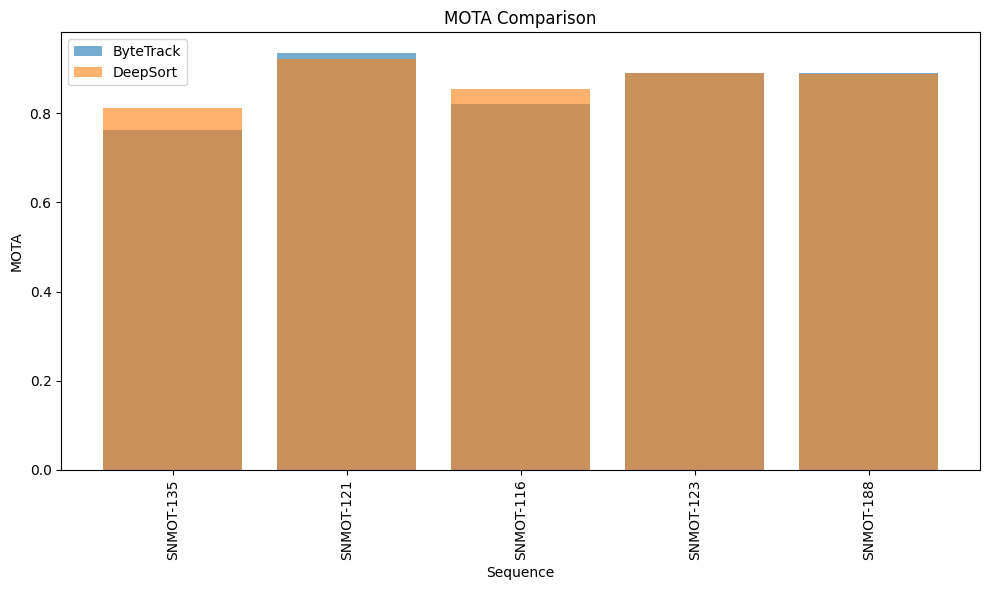

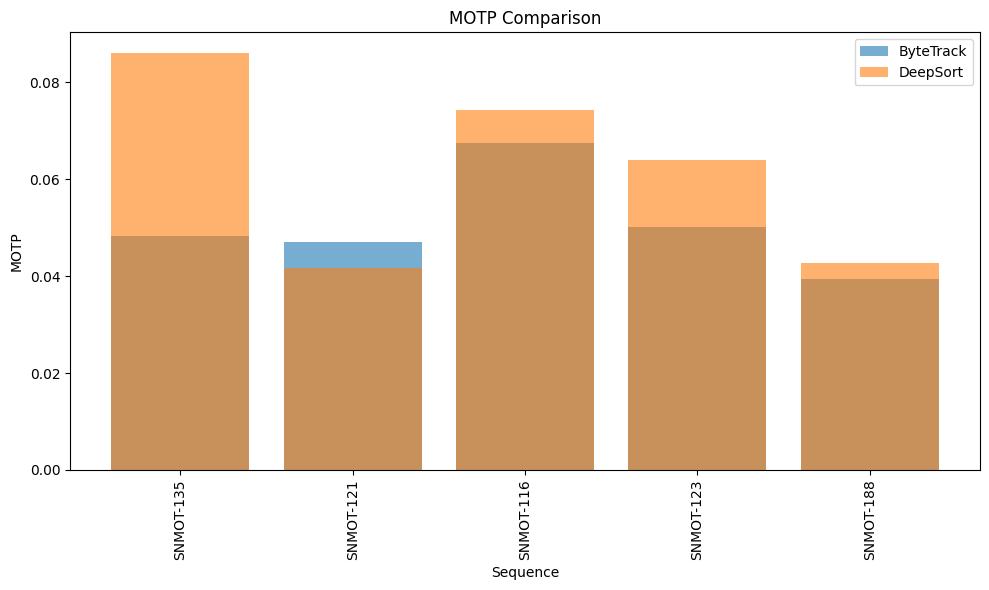

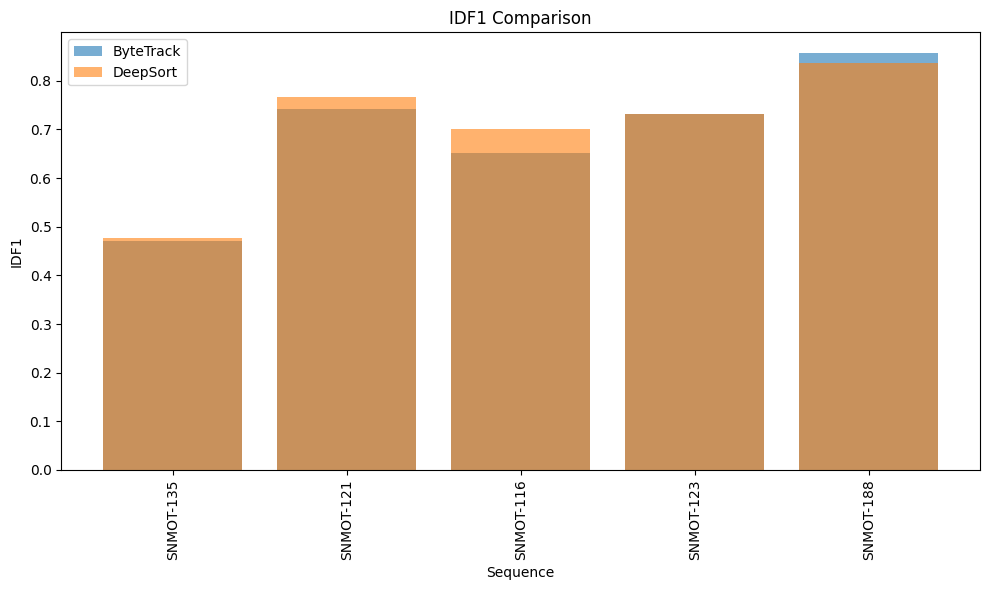

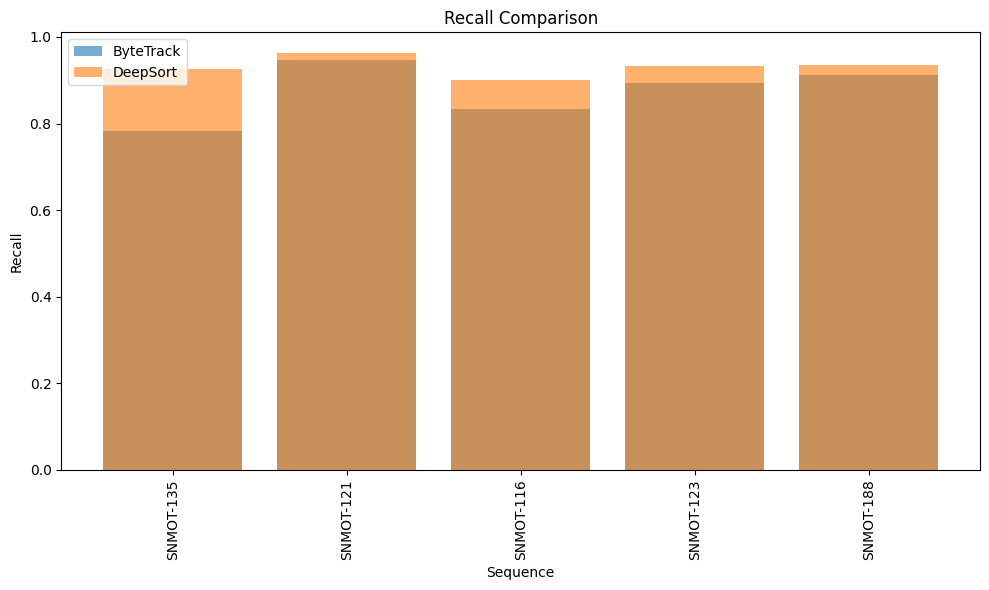

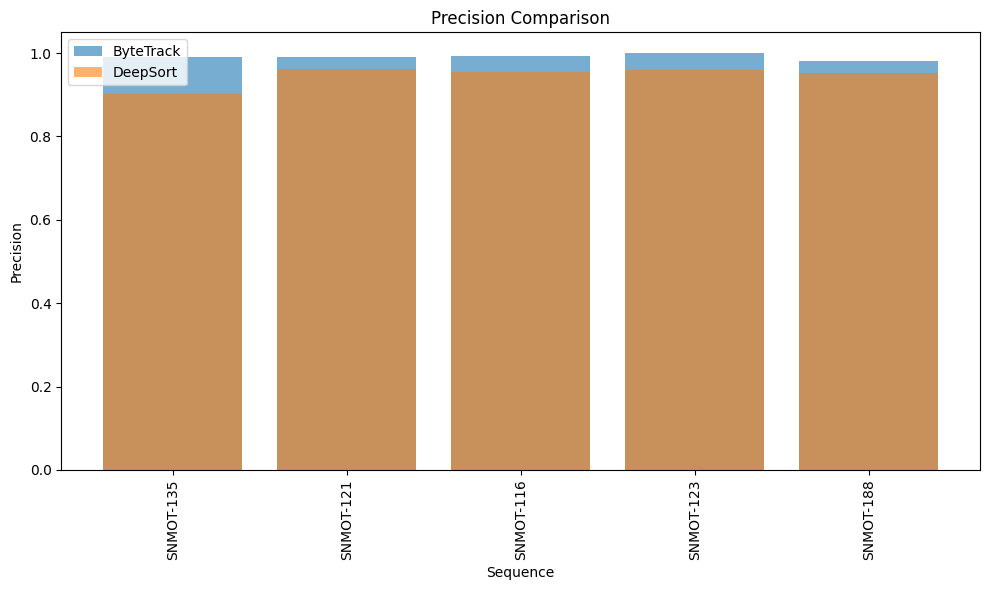

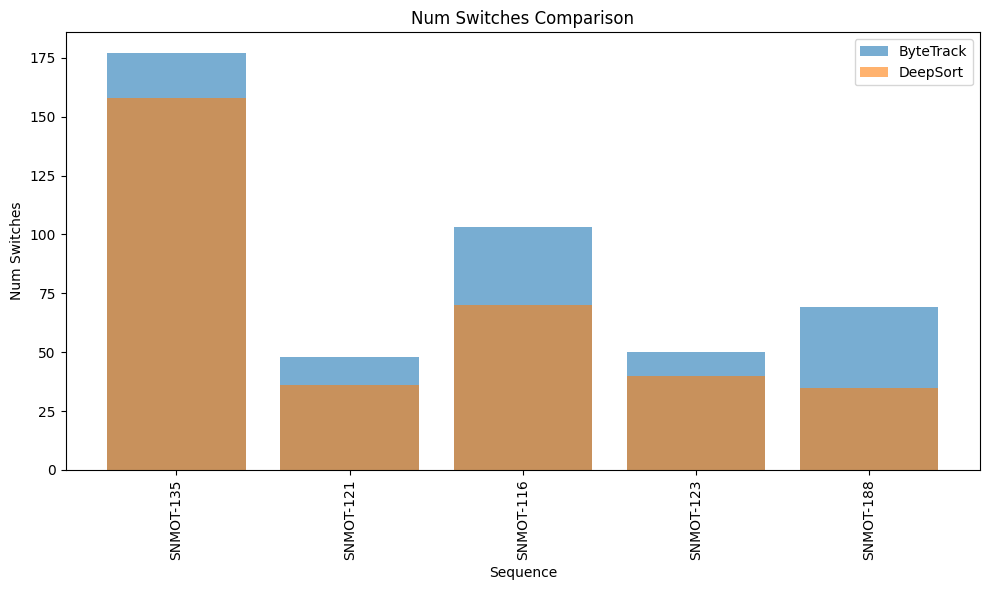

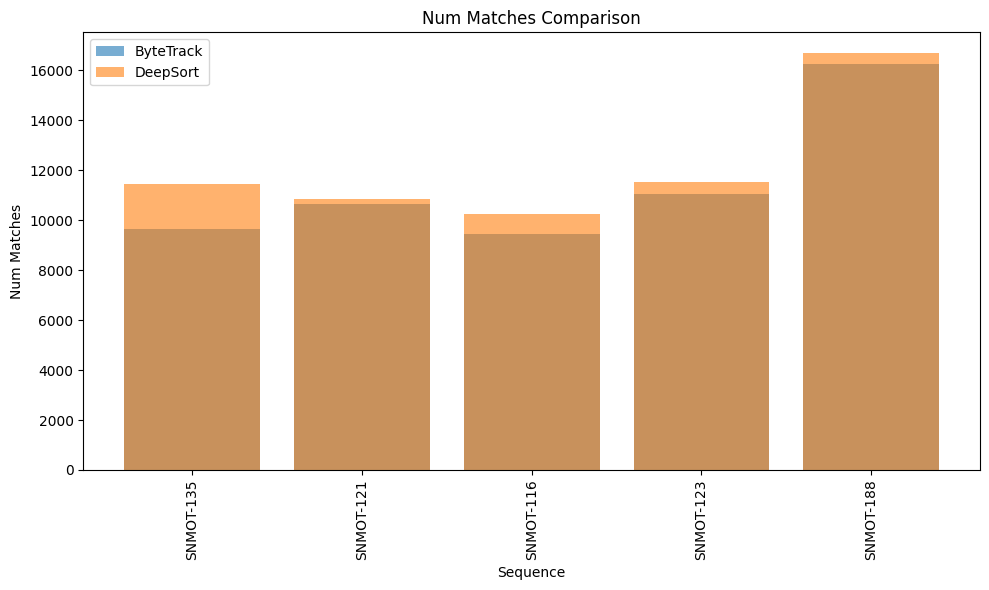

In [19]:
print_and_plot_comparison_with_switches_matches(results)

Based on the comparison results between **ByteTrack** and **DeepSORT**, here's an analysis:

1. **ByteTrack** excels in **precision**, meaning it makes fewer false-positive errors, and is more efficient in terms of computational resources. Its performance in **MOTP** is better than DeepSORT, indicating better position matching.
   
2. **DeepSORT**, on the other hand, outperforms ByteTrack in terms of **IDF1** and **recall**, making it better at handling identity consistency and detecting objects that are occluded or reappear after being lost. The integration of **ReID** in DeepSORT allows it to maintain identity across frames, which is especially useful in crowded or occlusion-heavy scenarios.

3. **ID switches** are noticeably higher in ByteTrack, which could be improved by incorporating a **ReID mechanism**, making it more robust in complex environments.

Both trackers perform well but in different areas:
- Use **ByteTrack** for scenarios requiring **high precision** and **real-time performance**.
- **DeepSORT** is more suited for **complex environments** with **occlusions** or when **identity consistency** is critical.



# Part 3

# 3.1 : Research

## 3.1.1

### **Common Problems in Multi-Object Tracking and Solutions**

1.  **Object Appearance-Reappearance and ID Switching**:
    *   **Problem**: Objects that disappear and then reappear, especially after long periods of being undetected, are often initialized as new tracks, leading to ID switches. Also, visually similar objects can cause ID switches after occlusion.
    *   **Solution**:
        *   **Re-ID Features**: Use deep learning-based re-identification (re-ID) features extracted from CNNs to better recognize and match objects, even after they have been out of view. The re-ID features can be updated using an exponential moving average (EMA) to make them more robust to occlusion and detection noise.
        *   **Appearance Model**: Integrate an appearance model that uses object features, helping to maintain consistent track IDs by considering the appearance of the object over time.
        *   **Track Queries**: Employ autoregressive track queries, as in TrackFormer, that embed an object’s spatial position and identity and follow it through a video sequence, helping preserve identity.
2.  **Occlusion Handling**:
    *   **Problem**: Occlusion, where objects are partially or fully hidden by other objects, often leads to missed detections and decreased tracking accuracy.
    *   **Solutions**:
        *   **Fuzzy Detection Model**: Implement a fuzzy detection model that considers the overlapping areas between tracks and their sizes. This model can calculate the detection probability based on the amount of overlap, and the proximity of the objects to the camera. The lower the bottom corner of the bounding box, the closer the object is to the camera and therefore more likely to cause occlusion.
        *   **Occlusion Reasoning**: Use high-level reasoning or model object depth to identify and handle occluded objects. Another popular method is to integrate occlusion attention modules based on spatial-temporal or spatial context of objects.
        *   **Data Association with Multiple Hypotheses**: Process multiple data association hypotheses instead of relying on a single hypothesis to handle occlusions more effectively.
        *   **Spatial-Temporal Information**: Use spatial-temporal information from tracklets to address severe object occlusions.
3.  **Missing Associations**:
    *   **Problem**: The same object is spread across multiple tracklets, particularly in online trackers that lack global information.
    *   **Solution**:
        *   **Appearance-Free Link Model (AFLink)**: Use an appearance-free model like AFLink to predict the connectivity between tracklets using only spatiotemporal information. This approach helps link short tracklets without relying on computationally expensive appearance models.
            *   **AFLink Details**:
                *   AFLink uses a two-branch framework. The first branch is a temporal module which uses three 1D convolution layers and a GRU layer to extract features along the temporal dimension. The second branch is a fusion module that uses a concatenation layer and a fully connected layer to integrate information along the feature dimension.
                *   The model is trained as a binary classifier to predict whether two tracklets belong to the same ID.
4.  **Missing Detections**:
    *  **Problem**: Objects are not detected due to occlusion, low resolution, or other issues resulting in false negatives.
    *  **Solution**:
         *   **Gaussian-Smoothed Interpolation (GSI)**: Apply GSI to compensate for missing detections by modeling nonlinear motion using Gaussian process regression. This is an effective way to generate more accurate and stable object locations in the gaps between detections.
            *   **GSI Details**:
                *   GSI uses Gaussian process regression to model nonlinear motion and fixes the interpolated bounding boxes. It is a type of detection noise filter that produces more accurate and stable localizations.
                *   The model uses an adaptive smoothness factor which is related to the length of the trajectory being interpolated and it helps model the motion of the object more accurately.
         *   **Track Augmentations**: Use augmentations during training, like the ones described in TrackFormer, such as sampling frames from a range of frames around the current frame to simulate camera motion or low frame rates, introducing false negatives by removing track queries to force the model to re-detect them, and using false positive track queries to simulate occlusions.
         *   **Kalman Filter**: A Kalman filter can be implemented to re-associate lost objects. It uses a dynamic model to predict the state of objects, and a measurement model to correct that prediction based on the observations. The Kalman Filter is also used to adaptively calculate the noise covariance.
5.  **Data Association**:
    *   **Problem**: Incorrectly matching objects across frames leads to ID switches and inaccurate trajectories.
    *   **Solution**:
        *   **Attention Mechanisms**: Use attention mechanisms to associate detections between frames by correlating each element of the input with respect to the others.
        *   **Global Information**: Consider using global information to refine tracking results and improve data association.
        *    **Matching Strategies**: When using a strong baseline tracker, it can be advantageous to use a simple vanilla matching strategy, instead of a matching cascade algorithm that includes redundant prior information.
6.  **Inconsistent Training**:
    *   **Problem**: Inconsistencies arise when detection and tracking tasks are trained separately.
    *   **Solution**:
        *   **Joint Training**: Combine detection and tracking processes in a unified manner to overcome global inconsistencies. DiffusionTrack is an example of a method that addresses this.
        *   **Consistent Model Structure**: Design a model that can handle detection and tracking using the same network structure, enabling the model to solve the two tasks simultaneously.

**Key Algorithms and Techniques**

*   **Labeled Random Finite Sets (LRFS)**:  LRFS framework is a versatile approach that integrates track management, state estimation, clutter rejection, and occlusion/miss-detection handling into a single Bayesian recursion. Specifically, the generalized labeled multi-Bernoulli (GLMB) filter addresses object appearance, disappearance, reappearance, and occlusion in a Bayesian sense.
*   **DeepSORT and StrongSORT**: DeepSORT is a tracking-by-detection method that uses a Kalman filter for motion prediction and a deep association metric for data association. StrongSORT improves upon DeepSORT by using stronger detection and feature embedding models, an EMA feature updating strategy, ECC for camera motion compensation, and replacing the matching cascade with a vanilla linear assignment. These improvements make StrongSORT a more robust baseline for MOT.
*   **Transformer Architecture**: TrackFormer uses a Transformer encoder-decoder architecture to perform multi-object tracking. The Transformer uses attention mechanisms for feature encoding and decoding, allowing the model to jointly reason about track initialization, identity, and spatio-temporal trajectories.
*   **Diffusion Models**: DiffusionTrack uses a diffusion model to perform object detection and data association as a consistent denoising process from paired noise boxes to object associations. It refines paired randomly generated boxes to detection and tracking results in a one-step or multi-step denoising process.

By addressing these common problems and applying these advanced algorithms, MOT models can achieve significant improvements in accuracy, robustness, and computational efficiency.


## 3.1.2

### **Optimizing Machine Learning Models for Productization**

Transforming machine learning (ML) models into reliable, scalable, and cost-effective products requires optimization to ensure that models perform well in real-world environments. This process ensures that models are not only accurate but also adaptable, maintainable, and efficient in production settings.

### **Why Optimization is Essential**

In production, optimization is key to making sure models meet the demands of speed, scalability, and reliability. For example, in real-time applications like fraud detection or recommendation systems, fast inference is critical. Models must also be scalable to handle large datasets and maintain performance across varying data loads. Moreover, optimizing for cost efficiency helps reduce computational overhead, which is especially important for complex models. Finally, models must be maintainable—able to adapt to shifts in data distribution over time without significant retraining.

### **Key Optimization Techniques**

- **Model Compression**: This technique reduces the size and computational demands of models while retaining their performance.  
   - **Quantization** reduces the precision of model weights (e.g., from 32-bit to 8-bit), making models smaller and faster without a major loss in accuracy.  
   - **Pruning** removes unnecessary neurons or model parameters to reduce size and improve speed.  
   - **Knowledge Distillation** transfers knowledge from a large, complex "teacher" model to a smaller, efficient "student" model, making it more lightweight for real-time applications.

- **Model Ensembling**: Ensembling involves combining multiple models to improve accuracy and robustness.  
   - Techniques like **Stacking**, **Bagging** (e.g., Random Forest), and **Boosting** (e.g., XGBoost) work together to reduce overfitting and improve predictions. However, they come with a trade-off: increased computational complexity and slower inference times due to running multiple models.

- **Parallelism & Distributed Computing**: These techniques are crucial for scaling models across large datasets and handling complex computations.  
   - **Model Parallelism** distributes different parts of the model across multiple processing units, ideal for large models in fields like NLP and computer vision.  
   - **Data Parallelism** distributes data across multiple devices for simultaneous training, speeding up the process and improving scalability.

- **AutoML (Automated Machine Learning)**: AutoML tools automate tasks like hyperparameter tuning, model selection, and feature engineering, streamlining the development process. These tools are especially useful for those without deep technical expertise but may not offer the same level of customization as manual model development.

- **Model Serving & Deployment Frameworks**: Efficient deployment is essential to ensure models are ready for production. Frameworks like **TensorFlow Serving**, **TorchServe**, and **ONNX** facilitate this process, providing scaling, monitoring, and update capabilities. While these tools simplify deployment, integrating them into existing systems may require specialized knowledge.

- **Hyperparameter Tuning**: Fine-tuning the hyperparameters of a model is essential to improve its performance. While **Grid Search** and **Random Search** explore different combinations exhaustively or randomly, **Bayesian Optimization** uses prior results to intelligently suggest new parameters, making the search process more efficient and resource-friendly.

### **Conclusion**

Optimizing ML models for productization is a critical process that ensures they meet the needs of real-world applications. By carefully selecting and combining various techniques—such as model compression, ensembling, parallelism, and AutoML—businesses can create models that are not only accurate but also efficient, scalable, and cost-effective in production environments. Optimization helps strike the right balance between performance and resource use, ensuring that ML systems deliver long-term value.

---